<a href="https://colab.research.google.com/github/SaketMunda/time-series-with-tensorflow/blob/master/time_series_with_tensorflow_bitpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 3: Time series forecasting in Tensorflow (BitPredict 💰📈)

The goal of this notebook is to get familiar working with Time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

In [1]:
# check for gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7966205f-306f-807b-c11a-42a526ac9f69)


## Get the data

To build a time series forecasting model, the first thing we're going to need is data.

So we're going to get the data of Bitcoin from some source like [Yahoo Finance](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1679356800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) in csv format.

I've downloaded it in csv format and currently in the [github repo](https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv).

Let's download it into the colab and view what it looks like.

In [2]:
!wget https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv

--2023-04-06 04:00:57--  https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255951 (250K) [text/plain]
Saving to: ‘BTC-USD.csv’

BTC-USD.csv         100%[===================>] 249.95K  --.-KB/s    in 0.01s   

2023-04-06 04:00:57 (24.5 MB/s) - ‘BTC-USD.csv’ saved [255951/255951]



### Importing time series data with pandas

In [3]:
## read with pandas
import pandas as pd

df = pd.read_csv('/content/BTC-USD.csv', parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-17,25055.123047,27787.812500,24955.169922,27423.929688,27423.929688,50730261335
2023-03-18,27448.117188,27725.953125,26636.261719,26965.878906,26965.878906,35723036817
2023-03-19,26969.503906,28440.560547,26907.716797,28038.675781,28038.675781,37769448859
2023-03-20,28041.601563,28527.724609,27242.880859,27767.236328,27767.236328,44774027664
2023-03-21,27784.175781,27980.882813,27737.007813,27964.888672,27964.888672,41356222464


So we have daily prices of Bitcoin from **17th Sept 2014** to **21st March 2023**, almost 8+ years

In [5]:
len(df)

3108

In [6]:
3108/365

8.515068493150684

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3108 entries, 2014-09-17 to 2023-03-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3108 non-null   float64
 1   High       3108 non-null   float64
 2   Low        3108 non-null   float64
 3   Close      3108 non-null   float64
 4   Adj Close  3108 non-null   float64
 5   Volume     3108 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 170.0 KB


Different types of Time Series Data

- **Trend**: time series has a clear long-term increase or decrease (may or may not be linear)
- **Seasonal**: time series affected by seasonal factors such as time of year (e.g increased sales towards end of year) or day of week
- **Cyclic**: time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns

For more insights on various kinds of Time series data, please read [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html)

To simplify let's remove some of the columns from our data so we're only left with a date index and the closing price

In [8]:
bitcoin_prices = pd.DataFrame(df["Adj Close"]).rename(columns={"Adj Close":"Price"})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781


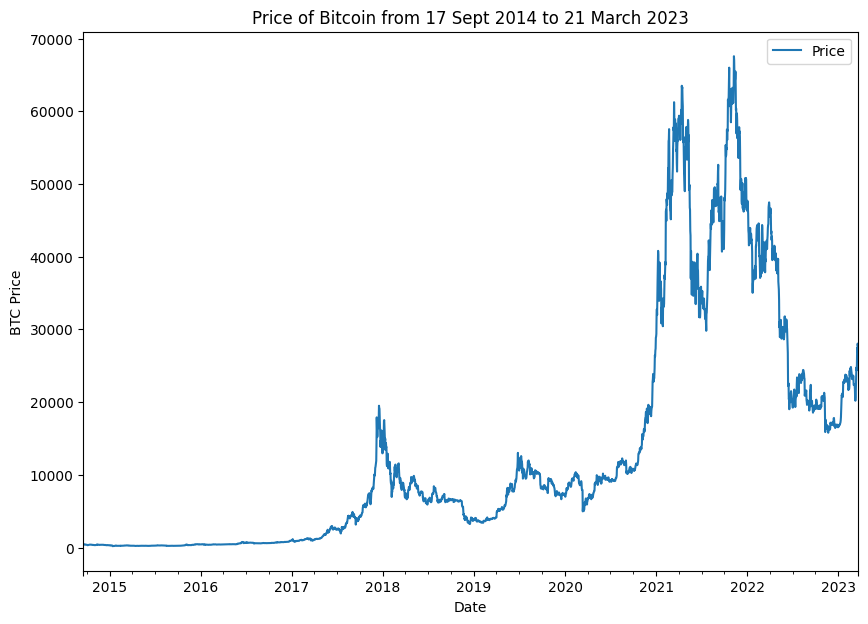

In [9]:
# let's plot everything
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.legend()
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

### Importing time series data with Python's CSV module

In [10]:
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC-USD.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates
    btc_price.append(float(line[5])) # get the adjusted closing price

# view first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Let's plot this

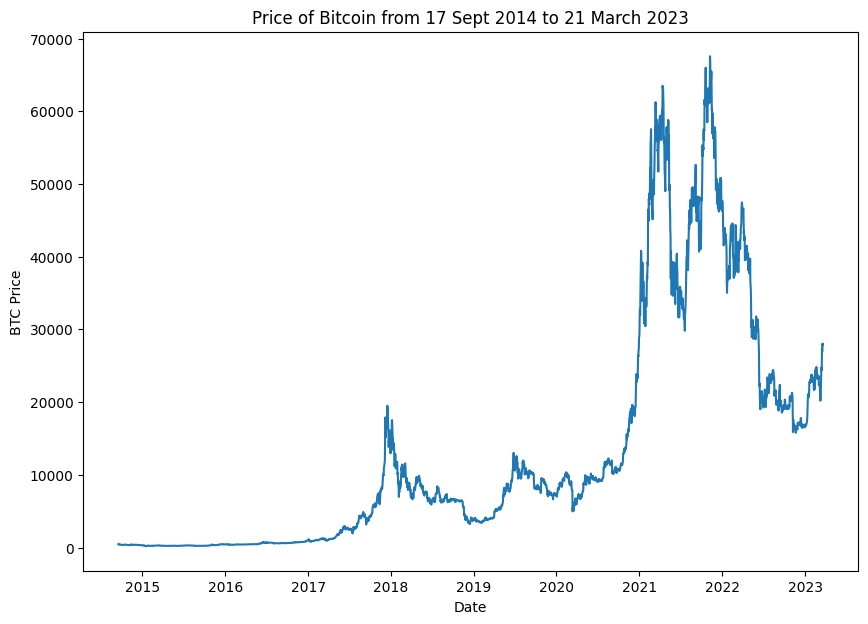

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

## Format Data Part 1 : Create train and test sets for Time Series data

Before we create splits we want to know what kind of data we have.

In time series problems, you'll either have **univariate** and **multivariate** data.

- Univariate time series data deals with one variable, for example using the price of bitcoin to predict the price of bitcoin
- Multivariate time series data deals with more than one variable, for example predicting the price of bitcoin using the price of bitcoin and block rewards and volume

### Create Train and Test sets for time series (wrong way)


In [12]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2486,), (622,), (2486,), (622,))

Looks like the splits worked well, but let's not trust numbers on a page, visualize, visualize and visualize

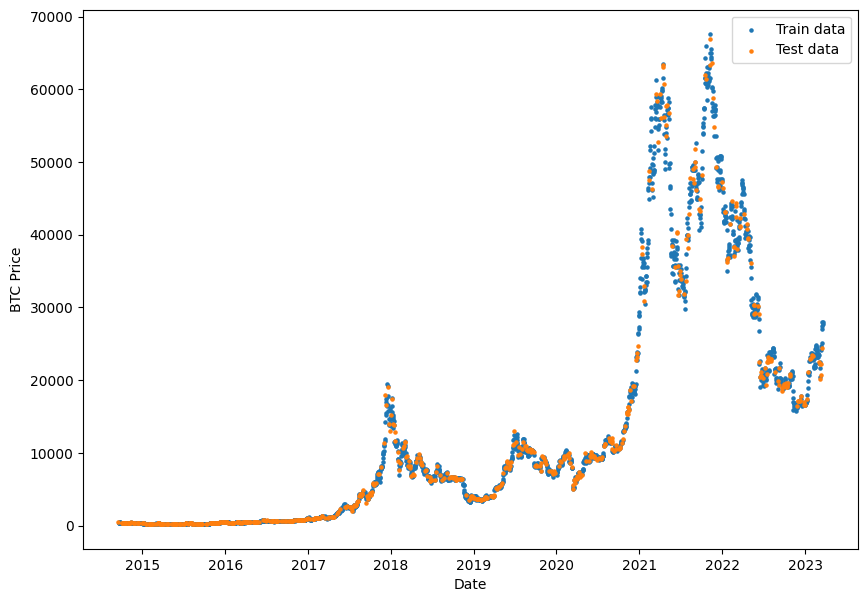

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.legend();

Since this is a time component so the split should be continous, if there is no time component then random split will work but since we are going to forecast the future, then we need past data.

### Create Train and Test sets for time series (the right way)

In [14]:
split_size = int(0.8 * len(prices)) # 80% of train sets and 20% of test sets

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]



Now if we visualize the plot,

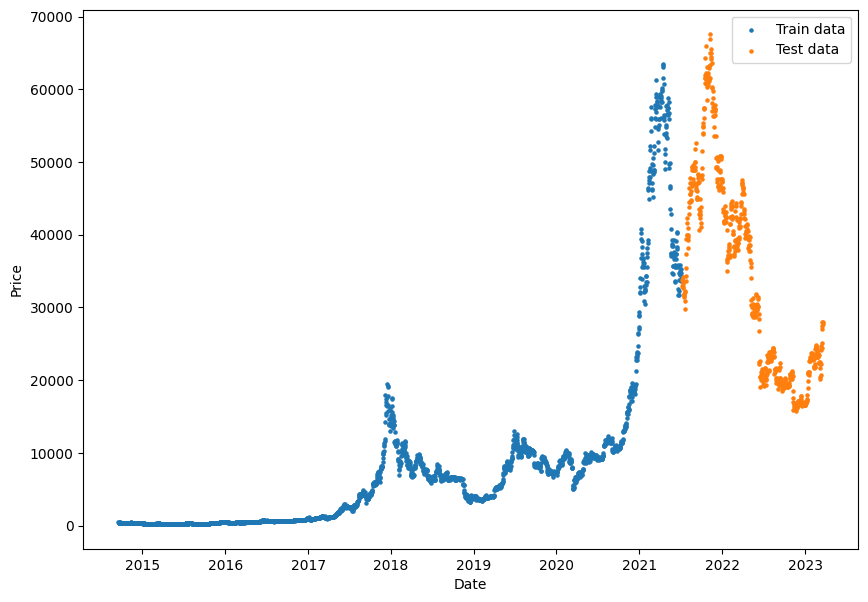

In [15]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend();

This is the correct way of splitting the data of time series problem. The plot should look like above.

### Creating a plotting function

Rather than retyping `matplotlib` commands to continously plot data, let's make a plotting function we can reuse later

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a time series plot on timesteps (a series of points in time) against values
  (a series of values across timesteps)

  Parameters
  ------------
  timesteps: array of timesteps
  values: array of values across time
  format: style of plot, default '.'
  start: where to start the plot
  end: where to end the plot
  label: label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

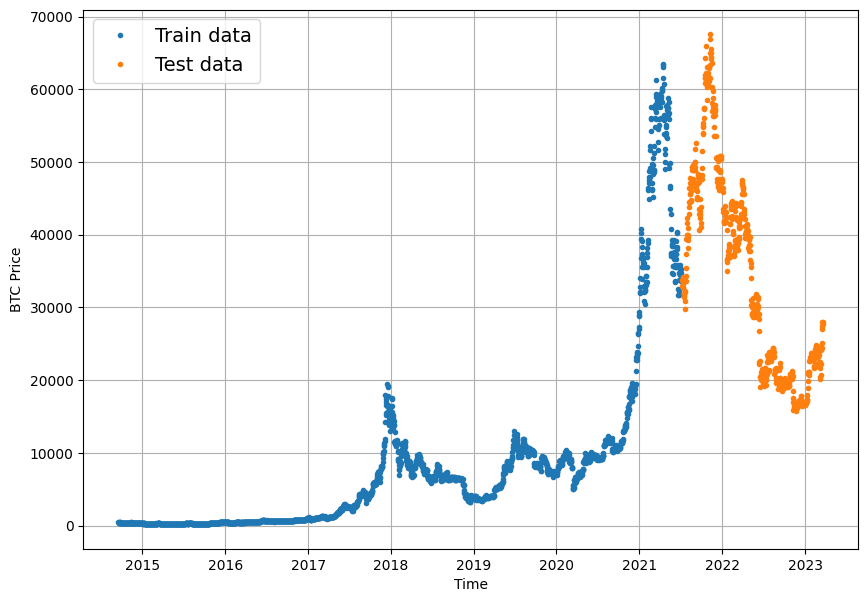

In [17]:
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

## Modelling Experiments

There are two terms that we should be familiar with, **horizon** and **window**,
- **horizon**: number of timesteps to predict into future
- **window**: number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for Tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and window would be 7.


List of modelling experiments we are going to perform,


| **Model Number** | **Model Type** | **Horizon Size** | **Window Size** | **Extra data** |
|-------------|--------------|------------|------------|------------|
| 0 | Naive forecast (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | same as 1 (but with univariate) | 1 | 7 | Block reward size/Volume |
| 7 | [N-Beats Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA |
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

## Model 0 : Naive forecast (baseline)

One of the most common baseline models for time series forecasting is naive model, (also called the naive forecast), requires no training at all.

That's because all the naive model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep `t`(y-hat) is equal to the value at timestep `t-1`(the previous timestep)

In an open system (like a stock market or crypto market), you'll often find beating the naive forecast with any kind of model is quite hard.

> 🔑 **Note**: an **open system** is a system where inputs and outputs can freely flow, such as market (stock or crypto), whereas a **closed system** the inputs and outputs are contained within the system (like a poker game with friends, as we know the buy in and how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [18]:
# create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:] # view first and last 10

(array([32877.371094, 33798.011719, 33520.519531, 34240.1875  ,
        33155.847656, 32702.025391, 32822.347656, 31780.730469,
        31421.539063, 31533.068359]),
 array([20632.410156, 22163.949219, 24197.533203, 24746.074219,
        24375.960938, 25052.789063, 27423.929688, 26965.878906,
        28038.675781, 27767.236328]))

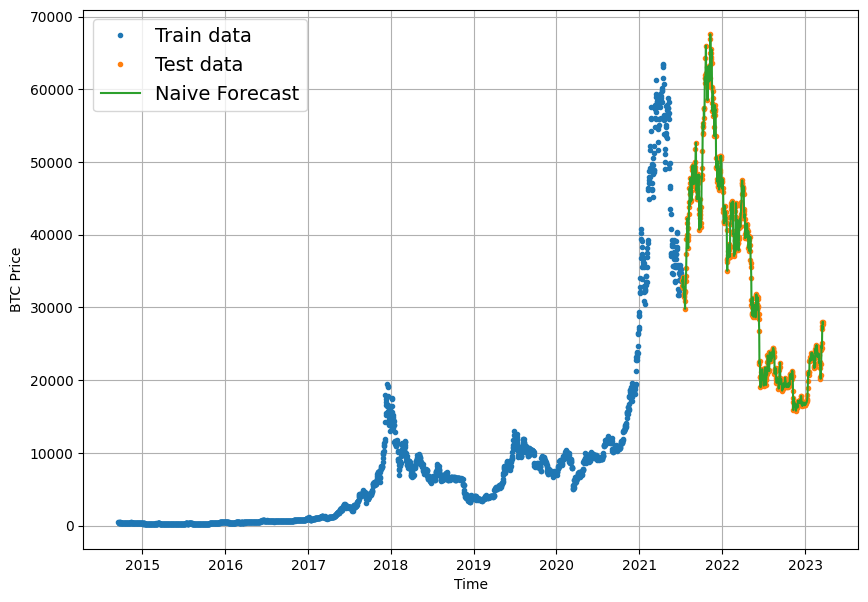

In [19]:
# plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast");

Let's zoom it and only plot the test and naive forecast


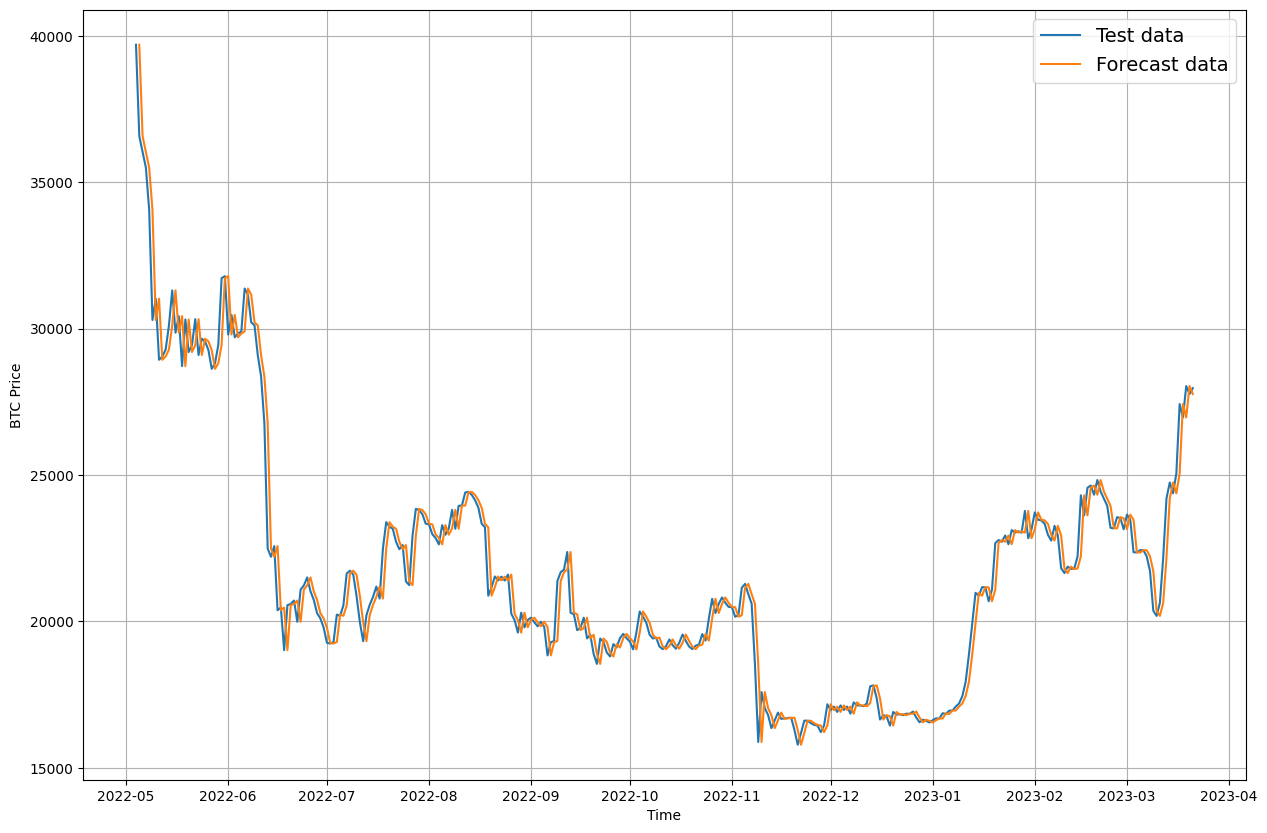

In [20]:
plt.figure(figsize=(15,10))
offset=300
plot_time_series(timesteps=X_test, values=y_test, start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format="-", label="Forecast data");

When we zoom in we see the naive forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a Time series model

Time series problem is often involves predicting a number which is the same output as Regression model, so we can similar types of metrics to evaluate Time series model, but let's see what are they, but thing to note for all the metrics, **lower the better** (for example an MAE of 0 is better than MAE 100).

### Scale Dependent Errors

These are metrics which can be used to compare time series values and forecasts which are in same scale.

for example, predicting the price of Bitcoin using historical prices in USD versus forecasting values in USD

| Metric | Details | Code |
| ------ |------ |------ |
| MAE (mean absolute error) |Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median | `tf.keras.metrics.mean_absolute_error()` |
| RMSE (root mean squared error) | Forecasts which minimises the RMSE lead to forecasts of the mean | `tf.sqrt(tf.keras.metrics.mean_square_error())` |

### Percentage Errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MAPE (mean absolute percentage error) | Most commonly used precentage error. May explode (not work) if `y=0` | `tf.keras.metrics.mean_absolute_percentage_error()` |
| sMAPE (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions | Custom implementation |


### Scaled Errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MASE (mean absolute scaled error) | MASE equals one of the naive forecast (or very close to one). A forecast which performs better than the naive should get < 1 MASE | See sktime's, [`mase_loss`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |


### Creating our own MASE function

We'll take inspiration from [sktime's](https://github.com/alan-turing-institute/sktime)(Scikit-Learn for time series) `MeanAbsoluteScaledError` class which calculates the MASE.
                                                                                                                          
                                                                                                                                                                                                                                                    


In [21]:
import tensorflow as tf

In [22]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))

  naive_mae_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:], y_true[:-1]))

  return mae / naive_mae_no_seasonality

Let's put each of our different evaluation metrics together into a function.

In [23]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_test[1:],
                               naive_forecast)

naive_results

{'mae': 807.2706,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000143}

Alright, this will be our baseline results to beat in further modelling experiment.

So if we look into `mae` result, it's `807.27` it means that each prediction in the naive forecast is off by **$807**

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

| Model/Library Name |	Resource |
| ---- | ---- |
| Moving average |	https://machinelearningmastery.com/ moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) |	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) |	https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) |	https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) |	https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) |	https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

We've got to window our time series.

Why do we window ?

Windowing is a method to turn a time series dataset into **supervised learning problem.**

In other words, we want to use windows of the past to predict the future.

For example, for a univariate time series, windowing for one week (window=7) to predict the next single value(horizon=1) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Similarly the price of Bitcoin look like,

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, these are just randomly picked)

In [25]:
HORIZON = 1
WINDOW_SIZE = 7

In [26]:
# Create a function which takes an array as input and return it in form of window and horizon
def get_labelled_windows(x, horizon=1):
  """
  Create labels for windowed dataset

  E.g if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6, 7] -> Output: ([1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)

print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we can do the same thing with entire time series data through Python loops, but to make things faster we can use [Numpy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).


Let's write a function which:

1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses Numpy indexing to create a 2D of multiple window steps, for example:

```
[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8]
```
3. Uses the 2D array of multiple window steps to index on a target series.
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.




In [28]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """

  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  #print(f"window_step: \n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  #print(f"Window indexes: \n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

Let's try with bitcoin prices

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3101, 3101)

In [30]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]} ")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987] 
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005] 
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988] 


In [31]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]} ")

Window: [22163.949219 24197.533203 24746.074219 24375.960938 25052.789063
 27423.929688 26965.878906] -> Label: [28038.675781] 
Window: [24197.533203 24746.074219 24375.960938 25052.789063 27423.929688
 26965.878906 28038.675781] -> Label: [27767.236328] 
Window: [24746.074219 24375.960938 25052.789063 27423.929688 26965.878906
 28038.675781 27767.236328] -> Label: [27964.888672] 


Anyways, we have written the whole function but this can also be achieved using [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)

### Turning windows into Training and Test sets



In [32]:
# Make the train and test split
def make_train_test_split(windows, labels, test_split=0.2):

  split_size=int(len(windows) * (1-test_split)) # this will be default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2480, 621, 2480, 621)

In [34]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

## Creating a Model Checkpoint

For a fair comparison between all the models that we're going to build, we need to train it with equal amount of epochs let's say 100 and then store the best performing model during training so that we can compare with the best performing model.

This can be possible using `ModelCheckpoint`.

`ModelCheckpoint` callback will monitor our model's performance during training and save the best model to the file by setting `save_best_only=True`


In [35]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window=7, horizon=1)

We're going to start by keeping it simple, `model_1` will have:
- A single dense layer with 128 hidden units and reLu activation
- An output layer with linear activation
- Adam optimizer and MAE, MSE metrics
- Batch size of 128

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(17)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')


# compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
12/20 [=================>............] - ETA: 0s - loss: 3028.1963 - mae: 3028.1963  

20/20 [==============================] - 10s 102ms/step - loss: 2344.5005 - mae: 2344.5005 - val_loss: 4452.7734 - val_mae: 4452.7734
Epoch 2/100
12/20 [=================>............] - ETA: 0s - loss: 689.0357 - mae: 689.0357  

20/20 [==============================] - 1s 65ms/step - loss: 675.3375 - mae: 675.3375 - val_loss: 2254.8523 - val_mae: 2254.8523
Epoch 3/100
12/20 [=================>............] - ETA: 0s - loss: 611.2961 - mae: 611.2961

20/20 [==============================] - 1s 56ms/step - loss: 594.0603 - mae: 594.0603 - val_loss: 1848.0066 - val_mae: 1848.0066
Epoch 4/100
20/20 [==============================] - 0s 13ms/step - loss: 575.5338 - mae: 575.5338 - val_loss: 1932.4913 - val_mae: 1932.4913
Epoch 5/100
20/20 [==============================] - ETA: 0s - loss: 562.6895 - mae: 562.6895

20/20 [==============================] - 1s 55ms/step - loss: 562.6895 - mae: 562.6895 - val_loss: 1752.8633 - val_mae: 1752.8633
Epoch 6/100
20/20 [==============================] - 0s 11ms/step - loss: 539.8254 - mae: 539.8254 - val_loss: 1813.7612 - val_mae: 1813.7612
Epoch 7/100
10/20 [==============>...............] - ETA: 0s - loss: 528.3449 - mae: 528.3449

20/20 [==============================] - 1s 49ms/step - loss: 517.4063 - mae: 517.4063 - val_loss: 1631.2675 - val_mae: 1631.2675
Epoch 8/100
20/20 [==============================] - 0s 8ms/step - loss: 534.2616 - mae: 534.2616 - val_loss: 1816.6699 - val_mae: 1816.6699
Epoch 9/100
20/20 [==============================] - 0s 10ms/step - loss: 530.6306 - mae: 530.6306 - val_loss: 1787.4919 - val_mae: 1787.4919
Epoch 10/100
19/20 [===========================>..] - ETA: 0s - loss: 476.1739 - mae: 476.1739

20/20 [==============================] - 2s 98ms/step - loss: 477.8822 - mae: 477.8822 - val_loss: 1572.2231 - val_mae: 1572.2231
Epoch 11/100
19/20 [===========================>..] - ETA: 0s - loss: 454.5737 - mae: 454.5737

20/20 [==============================] - 2s 101ms/step - loss: 459.3270 - mae: 459.3270 - val_loss: 1523.2429 - val_mae: 1523.2429
Epoch 12/100
20/20 [==============================] - 0s 9ms/step - loss: 447.0955 - mae: 447.0955 - val_loss: 1626.7657 - val_mae: 1626.7657
Epoch 13/100
20/20 [==============================] - ETA: 0s - loss: 436.8619 - mae: 436.8619

20/20 [==============================] - 1s 54ms/step - loss: 436.8619 - mae: 436.8619 - val_loss: 1318.1096 - val_mae: 1318.1096
Epoch 14/100
20/20 [==============================] - 0s 14ms/step - loss: 410.4919 - mae: 410.4919 - val_loss: 1342.9966 - val_mae: 1342.9966
Epoch 15/100
13/20 [==================>...........] - ETA: 0s - loss: 401.2682 - mae: 401.2682

20/20 [==============================] - 1s 49ms/step - loss: 393.3857 - mae: 393.3857 - val_loss: 1301.5927 - val_mae: 1301.5927
Epoch 16/100
12/20 [=================>............] - ETA: 0s - loss: 371.6422 - mae: 371.6422

20/20 [==============================] - 1s 63ms/step - loss: 382.1393 - mae: 382.1393 - val_loss: 1190.5548 - val_mae: 1190.5548
Epoch 17/100
20/20 [==============================] - 0s 12ms/step - loss: 368.2054 - mae: 368.2054 - val_loss: 1281.5764 - val_mae: 1281.5764
Epoch 18/100
14/20 [====================>.........] - ETA: 0s - loss: 366.8255 - mae: 366.8255

20/20 [==============================] - 1s 58ms/step - loss: 355.4063 - mae: 355.4063 - val_loss: 1163.4928 - val_mae: 1163.4928
Epoch 19/100
20/20 [==============================] - 0s 14ms/step - loss: 349.2313 - mae: 349.2313 - val_loss: 1494.5688 - val_mae: 1494.5688
Epoch 20/100
17/20 [========================>.....] - ETA: 0s - loss: 361.6361 - mae: 361.6361

20/20 [==============================] - 1s 55ms/step - loss: 352.4856 - mae: 352.4856 - val_loss: 1097.8093 - val_mae: 1097.8093
Epoch 21/100
20/20 [==============================] - ETA: 0s - loss: 324.9034 - mae: 324.9034

20/20 [==============================] - 1s 58ms/step - loss: 324.9034 - mae: 324.9034 - val_loss: 1042.4073 - val_mae: 1042.4073
Epoch 22/100
11/20 [===============>..............] - ETA: 0s - loss: 319.1562 - mae: 319.1562

20/20 [==============================] - 1s 65ms/step - loss: 319.0964 - mae: 319.0964 - val_loss: 994.6340 - val_mae: 994.6340
Epoch 23/100
20/20 [==============================] - 0s 6ms/step - loss: 307.4892 - mae: 307.4892 - val_loss: 1255.9612 - val_mae: 1255.9612
Epoch 24/100
20/20 [==============================] - 0s 8ms/step - loss: 327.0066 - mae: 327.0066 - val_loss: 1233.0420 - val_mae: 1233.0420
Epoch 25/100
13/20 [==================>...........] - ETA: 0s - loss: 303.4316 - mae: 303.4316

20/20 [==============================] - 1s 44ms/step - loss: 298.4965 - mae: 298.4965 - val_loss: 965.4577 - val_mae: 965.4577
Epoch 26/100
20/20 [==============================] - 0s 8ms/step - loss: 289.1113 - mae: 289.1113 - val_loss: 1071.6361 - val_mae: 1071.6361
Epoch 27/100
20/20 [==============================] - 0s 7ms/step - loss: 297.6150 - mae: 297.6150 - val_loss: 1063.0568 - val_mae: 1063.0568
Epoch 28/100
11/20 [===============>..............] - ETA: 0s - loss: 277.4877 - mae: 277.4877

20/20 [==============================] - 1s 41ms/step - loss: 291.9838 - mae: 291.9838 - val_loss: 952.6138 - val_mae: 952.6138
Epoch 29/100
13/20 [==================>...........] - ETA: 0s - loss: 287.9182 - mae: 287.9182

20/20 [==============================] - 1s 34ms/step - loss: 282.5005 - mae: 282.5005 - val_loss: 918.2142 - val_mae: 918.2142
Epoch 30/100
20/20 [==============================] - 0s 5ms/step - loss: 279.2002 - mae: 279.2002 - val_loss: 929.8837 - val_mae: 929.8837
Epoch 31/100
20/20 [==============================] - 0s 5ms/step - loss: 279.4692 - mae: 279.4692 - val_loss: 928.0579 - val_mae: 928.0579
Epoch 32/100
20/20 [==============================] - 0s 5ms/step - loss: 283.8766 - mae: 283.8766 - val_loss: 1068.3512 - val_mae: 1068.3512
Epoch 33/100
16/20 [=======================>......] - ETA: 0s - loss: 279.8395 - mae: 279.8395

20/20 [==============================] - 1s 28ms/step - loss: 287.1973 - mae: 287.1973 - val_loss: 911.0236 - val_mae: 911.0236
Epoch 34/100
18/20 [==========================>...] - ETA: 0s - loss: 276.5105 - mae: 276.5105

20/20 [==============================] - 1s 29ms/step - loss: 272.8808 - mae: 272.8808 - val_loss: 901.2261 - val_mae: 901.2261
Epoch 35/100
20/20 [==============================] - 0s 5ms/step - loss: 279.2221 - mae: 279.2221 - val_loss: 918.2396 - val_mae: 918.2396
Epoch 36/100
20/20 [==============================] - 0s 5ms/step - loss: 278.4744 - mae: 278.4744 - val_loss: 907.4524 - val_mae: 907.4524
Epoch 37/100
20/20 [==============================] - 0s 5ms/step - loss: 290.7845 - mae: 290.7845 - val_loss: 930.3790 - val_mae: 930.3790
Epoch 38/100
20/20 [==============================] - 0s 6ms/step - loss: 279.1815 - mae: 279.1815 - val_loss: 934.1571 - val_mae: 934.1571
Epoch 39/100
18/20 [==========================>...] - ETA: 0s - loss: 284.5146 - mae: 284.5146

20/20 [==============================] - 1s 29ms/step - loss: 287.0923 - mae: 287.0923 - val_loss: 889.2650 - val_mae: 889.2650
Epoch 40/100
20/20 [==============================] - 0s 6ms/step - loss: 328.4658 - mae: 328.4658 - val_loss: 1405.0009 - val_mae: 1405.0009
Epoch 41/100
20/20 [==============================] - 0s 5ms/step - loss: 325.0094 - mae: 325.0094 - val_loss: 1145.1740 - val_mae: 1145.1740
Epoch 42/100
20/20 [==============================] - 0s 5ms/step - loss: 284.2720 - mae: 284.2720 - val_loss: 909.9385 - val_mae: 909.9385
Epoch 43/100
20/20 [==============================] - 0s 6ms/step - loss: 269.5525 - mae: 269.5525 - val_loss: 892.5997 - val_mae: 892.5997
Epoch 44/100
20/20 [==============================] - 0s 6ms/step - loss: 281.0495 - mae: 281.0495 - val_loss: 899.3279 - val_mae: 899.3279
Epoch 45/100
20/20 [==============================] - 0s 5ms/step - loss: 282.8904 - mae: 282.8904 - val_loss: 889.4775 - val_mae: 889.4775
Epoch 46/100
19/20 [========

20/20 [==============================] - 1s 29ms/step - loss: 272.8995 - mae: 272.8995 - val_loss: 873.3857 - val_mae: 873.3857
Epoch 47/100
20/20 [==============================] - 0s 5ms/step - loss: 266.9114 - mae: 266.9114 - val_loss: 873.7917 - val_mae: 873.7917
Epoch 48/100
18/20 [==========================>...] - ETA: 0s - loss: 269.9200 - mae: 269.9200

20/20 [==============================] - 1s 41ms/step - loss: 270.1368 - mae: 270.1368 - val_loss: 873.2059 - val_mae: 873.2059
Epoch 49/100
20/20 [==============================] - 0s 6ms/step - loss: 273.4240 - mae: 273.4240 - val_loss: 901.0480 - val_mae: 901.0480
Epoch 50/100
19/20 [===========================>..] - ETA: 0s - loss: 265.1856 - mae: 265.1856

20/20 [==============================] - 1s 28ms/step - loss: 264.2295 - mae: 264.2295 - val_loss: 861.8026 - val_mae: 861.8026
Epoch 51/100
20/20 [==============================] - 0s 5ms/step - loss: 263.6222 - mae: 263.6222 - val_loss: 941.6255 - val_mae: 941.6255
Epoch 52/100
20/20 [==============================] - 0s 6ms/step - loss: 261.6300 - mae: 261.6300 - val_loss: 866.9962 - val_mae: 866.9962
Epoch 53/100
20/20 [==============================] - 0s 5ms/step - loss: 263.3845 - mae: 263.3845 - val_loss: 868.5038 - val_mae: 868.5038
Epoch 54/100
20/20 [==============================] - 0s 6ms/step - loss: 265.1214 - mae: 265.1214 - val_loss: 919.0699 - val_mae: 919.0699
Epoch 55/100
20/20 [==============================] - 0s 6ms/step - loss: 274.4754 - mae: 274.4754 - val_loss: 914.7452 - val_mae: 914.7452
Epoch 56/100
20/20 [==============================] - 0s 5ms/step - loss: 269.3275 - mae: 269.3275 - val_loss: 878.8763 - val_mae: 878.8763
Epoch 57/100
20/20 [============

20/20 [==============================] - 1s 29ms/step - loss: 264.6589 - mae: 264.6589 - val_loss: 849.0508 - val_mae: 849.0508
Epoch 60/100
20/20 [==============================] - 0s 6ms/step - loss: 261.5294 - mae: 261.5294 - val_loss: 891.1010 - val_mae: 891.1010
Epoch 61/100
20/20 [==============================] - 0s 6ms/step - loss: 264.0783 - mae: 264.0783 - val_loss: 860.4557 - val_mae: 860.4557
Epoch 62/100
20/20 [==============================] - 0s 5ms/step - loss: 269.5304 - mae: 269.5304 - val_loss: 1009.5090 - val_mae: 1009.5090
Epoch 63/100
20/20 [==============================] - 0s 6ms/step - loss: 271.4150 - mae: 271.4150 - val_loss: 968.8250 - val_mae: 968.8250
Epoch 64/100
20/20 [==============================] - 0s 5ms/step - loss: 264.7948 - mae: 264.7948 - val_loss: 856.1525 - val_mae: 856.1525
Epoch 65/100
20/20 [==============================] - 0s 5ms/step - loss: 255.7581 - mae: 255.7581 - val_loss: 882.0996 - val_mae: 882.0996
Epoch 66/100
20/20 [==========

20/20 [==============================] - 1s 28ms/step - loss: 261.4533 - mae: 261.4533 - val_loss: 843.1263 - val_mae: 843.1263
Epoch 69/100
20/20 [==============================] - 0s 6ms/step - loss: 260.4091 - mae: 260.4091 - val_loss: 1031.9518 - val_mae: 1031.9518
Epoch 70/100
20/20 [==============================] - 0s 6ms/step - loss: 272.7614 - mae: 272.7614 - val_loss: 884.7750 - val_mae: 884.7750
Epoch 71/100
14/20 [====================>.........] - ETA: 0s - loss: 269.5187 - mae: 269.5187

20/20 [==============================] - 1s 29ms/step - loss: 267.3810 - mae: 267.3810 - val_loss: 838.7218 - val_mae: 838.7218
Epoch 72/100
20/20 [==============================] - 0s 5ms/step - loss: 267.9847 - mae: 267.9847 - val_loss: 1119.8162 - val_mae: 1119.8162
Epoch 73/100
20/20 [==============================] - 0s 5ms/step - loss: 282.8744 - mae: 282.8744 - val_loss: 954.1052 - val_mae: 954.1052
Epoch 74/100
20/20 [==============================] - 0s 6ms/step - loss: 251.2908 - mae: 251.2908 - val_loss: 860.8987 - val_mae: 860.8987
Epoch 75/100
20/20 [==============================] - 0s 6ms/step - loss: 256.4019 - mae: 256.4019 - val_loss: 880.8610 - val_mae: 880.8610
Epoch 76/100
15/20 [=====================>........] - ETA: 0s - loss: 245.2036 - mae: 245.2036

20/20 [==============================] - 1s 38ms/step - loss: 255.8718 - mae: 255.8718 - val_loss: 834.8502 - val_mae: 834.8502
Epoch 77/100
20/20 [==============================] - 0s 8ms/step - loss: 264.6269 - mae: 264.6269 - val_loss: 841.6839 - val_mae: 841.6839
Epoch 78/100
20/20 [==============================] - 0s 9ms/step - loss: 268.9901 - mae: 268.9901 - val_loss: 976.7386 - val_mae: 976.7386
Epoch 79/100
20/20 [==============================] - 0s 8ms/step - loss: 265.1021 - mae: 265.1021 - val_loss: 842.2911 - val_mae: 842.2911
Epoch 80/100
20/20 [==============================] - 0s 7ms/step - loss: 274.6842 - mae: 274.6842 - val_loss: 949.7756 - val_mae: 949.7756
Epoch 81/100
20/20 [==============================] - 0s 7ms/step - loss: 264.3048 - mae: 264.3048 - val_loss: 848.4798 - val_mae: 848.4798
Epoch 82/100
20/20 [==============================] - 0s 7ms/step - loss: 274.2946 - mae: 274.2946 - val_loss: 1342.7246 - val_mae: 1342.7246
Epoch 83/100
20/20 [==========

20/20 [==============================] - 1s 28ms/step - loss: 253.2844 - mae: 253.2844 - val_loss: 833.9126 - val_mae: 833.9126
Epoch 93/100
18/20 [==========================>...] - ETA: 0s - loss: 252.6889 - mae: 252.6889

20/20 [==============================] - 1s 28ms/step - loss: 256.4541 - mae: 256.4541 - val_loss: 827.7332 - val_mae: 827.7332
Epoch 94/100
20/20 [==============================] - 0s 6ms/step - loss: 255.5872 - mae: 255.5872 - val_loss: 1030.0227 - val_mae: 1030.0227
Epoch 95/100
20/20 [==============================] - 0s 5ms/step - loss: 284.6915 - mae: 284.6915 - val_loss: 1142.3781 - val_mae: 1142.3781
Epoch 96/100
20/20 [==============================] - 0s 5ms/step - loss: 270.5071 - mae: 270.5071 - val_loss: 941.6833 - val_mae: 941.6833
Epoch 97/100
20/20 [==============================] - 0s 5ms/step - loss: 282.0981 - mae: 282.0981 - val_loss: 997.9051 - val_mae: 997.9051
Epoch 98/100
20/20 [==============================] - 0s 5ms/step - loss: 257.1299 - mae: 257.1299 - val_loss: 862.2359 - val_mae: 862.2359
Epoch 99/100
20/20 [==============================] - 0s 5ms/step - loss: 255.9097 - mae: 255.9097 - val_loss: 933.1328 - val_mae: 933.1328
Epoch 100/100
20/20 [=======

In [37]:
# evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 920.6979 - mae: 920.6979


[920.6979370117188, 920.6979370117188]

This is the last epoch's evaluation results, but let's check the best model weights

In [38]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 827.7332 - mae: 827.7332


[827.733154296875, 827.733154296875]

Okay, not bad but what about the predictions on `model_1`. Let's create a function to make predictions and then evaluate the results of model_1 on those predictions.

### Make Prediction function

In [39]:
def make_predictions(model, input_data):
  """
  Returns the prediction result on input_data for the model passed.
  """
  y_preds = model.predict(input_data)
  return tf.squeeze(y_preds) # returns 1D array of predictions

In [40]:
model_1_preds = make_predictions(model_1, test_windows)
model_1_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([32965.156, 33563.633, 33539.383, 34093.496, 33395.953, 32741.818,
       32744.71 , 31877.2  , 31380.123, 31420.664], dtype=float32)>

In [41]:
test_labels.shape, model_1_preds.shape

((621, 1), TensorShape([621]))

In [42]:
# evaluate results
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 827.7332,
 'mse': 1553035.6,
 'rmse': 1246.2085,
 'mape': 2.3926423,
 'mase': 1.0000143}

In [43]:
# view the naive results
naive_results

{'mae': 807.2706,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000143}

Naive model results (baseline) is beating our first dense model(model_1) but that's expected. Let's do further visualization by plotting the prediction in the graph.

### Plot `model_1` results

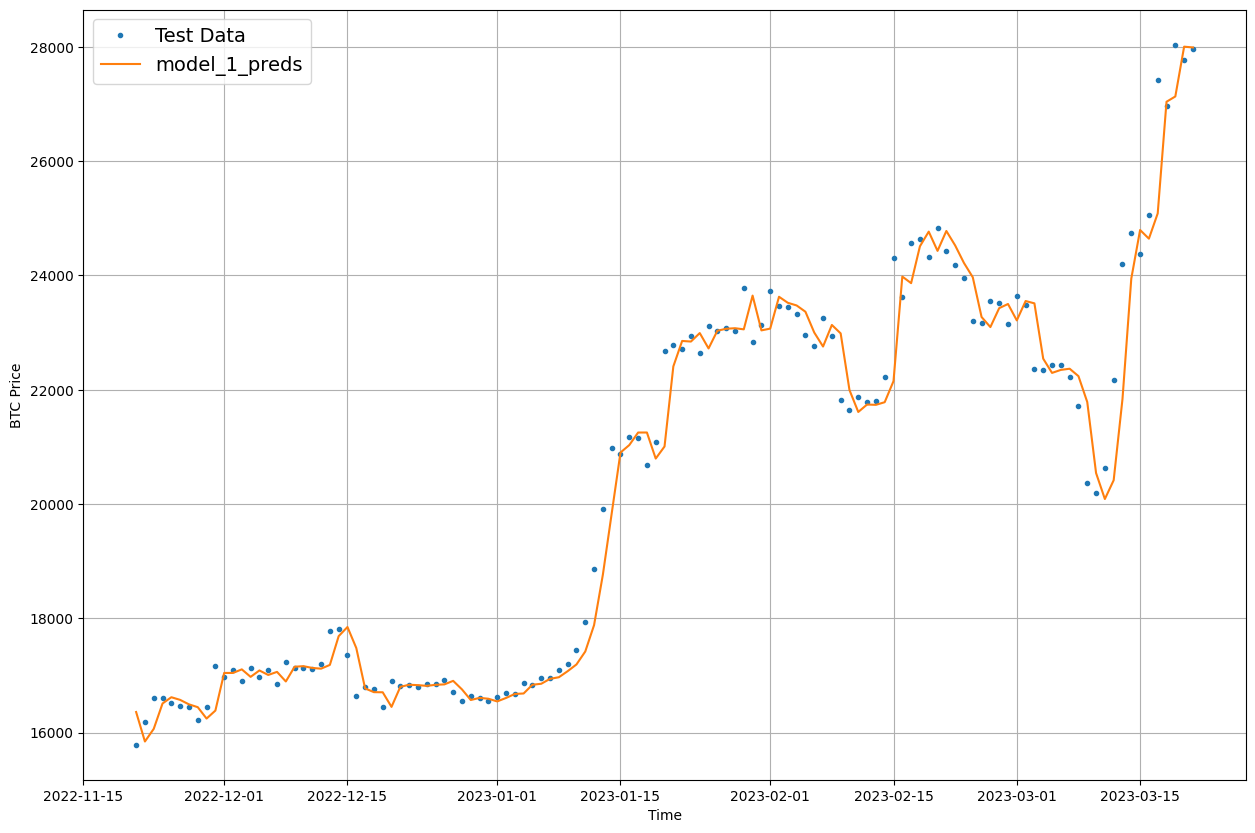

In [44]:
offset = 500
plt.figure(figsize=(15, 10))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-",label="model_1_preds")

Something wrong with the predictions ? 

And also predictions are little behind the actual values. For more about this, [Read Autocorrelation](https://otexts.com/fpp3/acf.html)

Since they're on the test dataset. So they're not actual forecasts that we are trying for predicting a price.

With our current model setup, we've to make forecasts for the future.

## Model 2: Dense (window=30, horizon=1)

In this model we are going to predict on window_size 30, that is past 30 days of bitcoin prices to predict next day of bitcoin price.

In [45]:
HORIZON=1
WINDOW_SIZE=30

In [46]:
# Reset the windows and labels with 30 day prices of bitcoin
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows[:2], full_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996],
        [391.441986]]))

In [47]:
# Create train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2462, 616, 2462, 616)

In [48]:
# Now ready to create our dense model

tf.random.set_seed(17)

# Create the model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], 'model_2_dense')

# compile the model
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [49]:
# evaluate the model with the last epochs 
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 874.2000


874.199951171875

In [50]:
# Evaluation on the best model
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 874.1443


874.144287109375

In [51]:
# prediction on model_2
model_2_preds = make_predictions(model_2, test_windows)

# evaluate the results
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

20/20 [==============================] - 0s 2ms/step


{'mae': 874.1443,
 'mse': 1687723.6,
 'rmse': 1299.1241,
 'mape': 2.546832,
 'mase': 0.99996686}

In [52]:
model_1_results

{'mae': 827.7332,
 'mse': 1553035.6,
 'rmse': 1246.2085,
 'mape': 2.3926423,
 'mase': 1.0000143}

It looks like `model_1` performs better than `model_2`.

Also, smaller windows size is performing better so in that case we can create window size of something like 5 days.



How do the predictions look ?

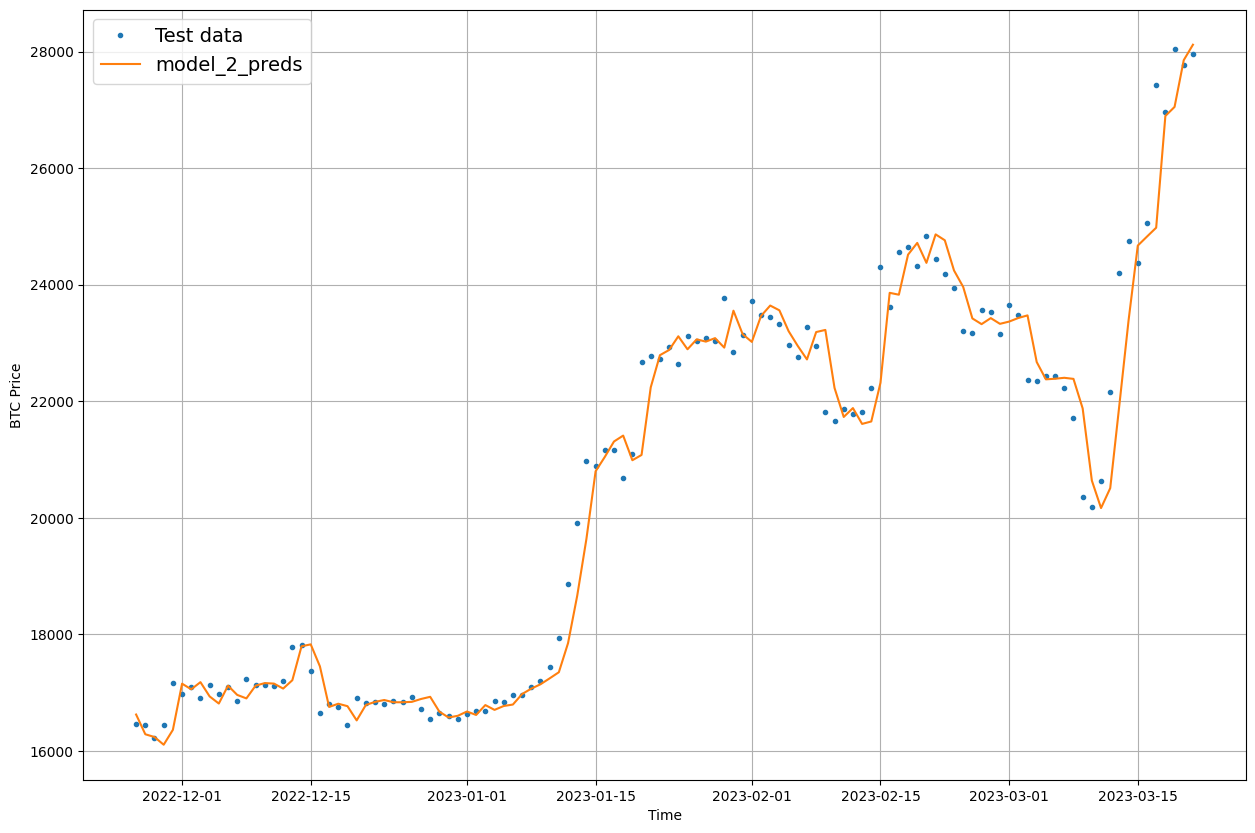

In [53]:
offset = 500
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3 : Dense(window=30, horizon=7)

In [54]:
HORIZON=7
WINDOW_SIZE=30

# create windows and labels
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

train_windows[:2], train_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996, 391.441986, 389.54599 , 382.845001, 386.475006,
         383.15799 , 358.416992],
        [391.441986, 389.54599 , 382.845001, 386.475006, 383.1579

In [55]:
len(train_windows), len(test_windows)

(2457, 615)

In [56]:
tf.random.set_seed(17)

# Create Model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit 
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [57]:
# evaluation on last epoch
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1747.0413


1747.041259765625

In [58]:
# load the best model and evaluate
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense/')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 1747.0413


1747.041259765625

This is going to be large because we are trying to predict 7 days in advance, for example we want to predict the weather in advance of 7 days. So there will be higher chances of wrong predictibility.

In [59]:
# Make prediction and see the results
model_3_preds = make_predictions(model_3, test_windows)

20/20 [==============================] - 0s 2ms/step


In [60]:
model_3_preds.shape, test_labels.shape

(TensorShape([615, 7]), (615, 7))

In [61]:
# view the results
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': array([ 943.8965 ,  928.78406,  919.0636 , 1889.5734 , 1875.4154 ,
        1104.9894 , 1291.658  ,  875.3926 , 1066.7623 , 1389.392  ,
        1930.1945 , 2853.5396 , 5057.3677 , 4690.216  , 4947.954  ,
        5188.5547 , 5224.503  , 4760.066  , 3276.5598 , 1712.6272 ,
         908.601  , 1031.5764 , 1634.4525 , 2361.6614 , 1959.9905 ,
        2963.7812 , 4878.909  , 4946.6577 , 4382.538  , 3597.0156 ,
        2099.7957 , 1971.5173 ,  757.7857 ,  931.1568 , 1424.2834 ,
        1026.202  , 1285.4705 , 1926.7333 , 1697.0703 , 2025.0251 ,
        2625.8281 , 3253.2114 , 2483.7104 , 1131.1741 , 1465.029  ,
        1774.173  , 2350.0078 , 1255.6569 , 1160.255  , 1291.8611 ,
         591.68585,  891.52734, 1128.0553 , 2302.2083 , 2659.3655 ,
        2159.9292 , 2695.1372 , 3309.9648 , 4084.3567 , 5155.189  ,
        7130.425  , 3565.73   , 1470.8633 , 1272.2103 , 1534.597  ,
        2439.639  , 2170.0972 , 2291.7417 , 2189.4636 , 2781.7444 ,
        3379.423  , 3779.7114 , 4739.775 

This is multi-dimensional output because the predictions are getting evaluated across the HORIZON timesteps (7 predictions at a time).

To fix this we need to adjust our `evaluate_preds()` function.

In [62]:
tf.reduce_mean(model_3_results['mae'])

<tf.Tensor: shape=(), dtype=float32, numpy=1747.0413>

In [63]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # If horizon is greater than 1
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Let's evaulate our `model_3` now

In [64]:
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 1747.0413,
 'mse': 6469269.0,
 'rmse': 2010.1216,
 'mape': 5.1647983,
 'mase': 0.99998134}

In [65]:
model_2_results

{'mae': 874.1443,
 'mse': 1687723.6,
 'rmse': 1299.1241,
 'mape': 2.546832,
 'mase': 0.99996686}

`model_3` seems even worse compared to previous modelling experiments. Let's plot the predictions.

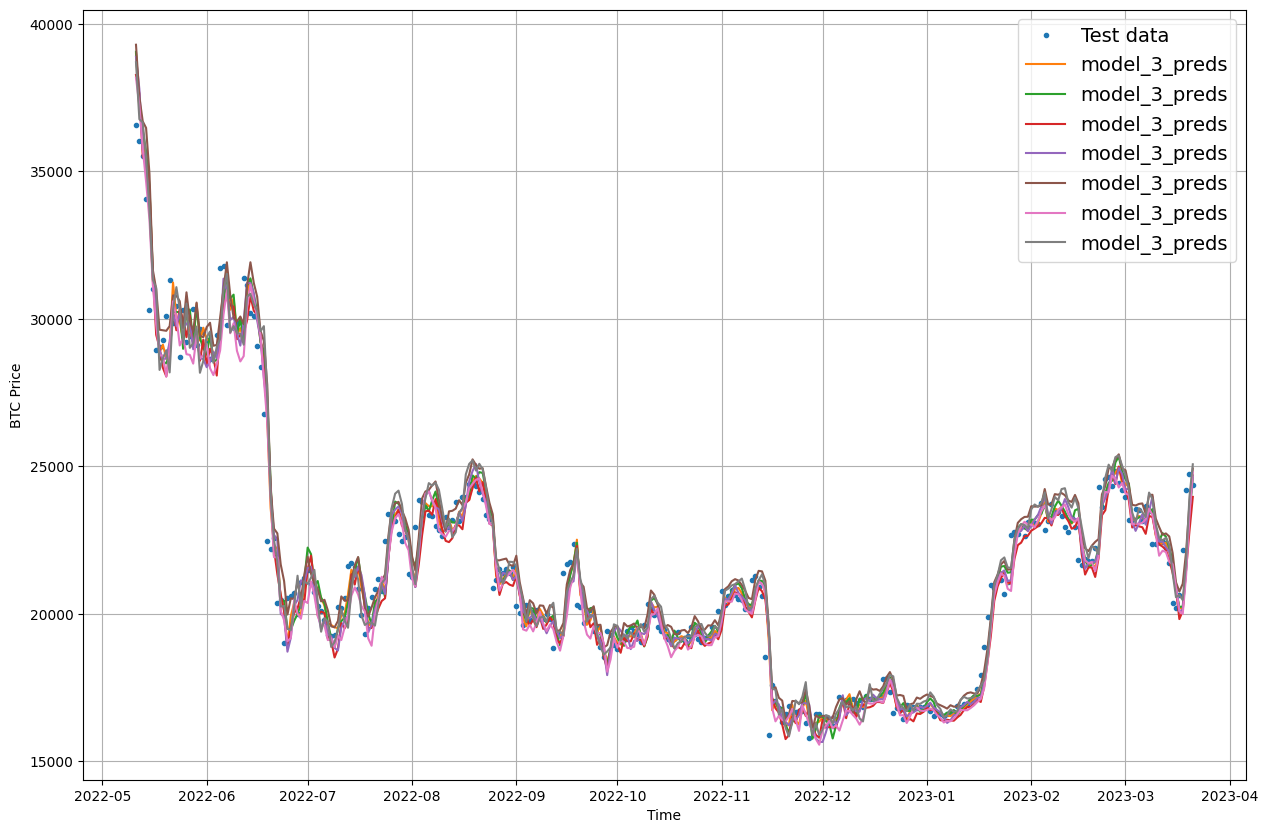

In [66]:
offset=300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds,start=offset,format="-", label="model_3_preds")

Since our predictions were multi-dimensional, the plot predictions also look like stacked every timesteps together.

Let's fix this by aggregating our model's predictions.

**Note**: Aggregating the results of the predictions lead to lose in information from it's original predictions because it was originally predicted for 7 days but if we aggregate it in 1 day then it'll lose the detailed predictions.

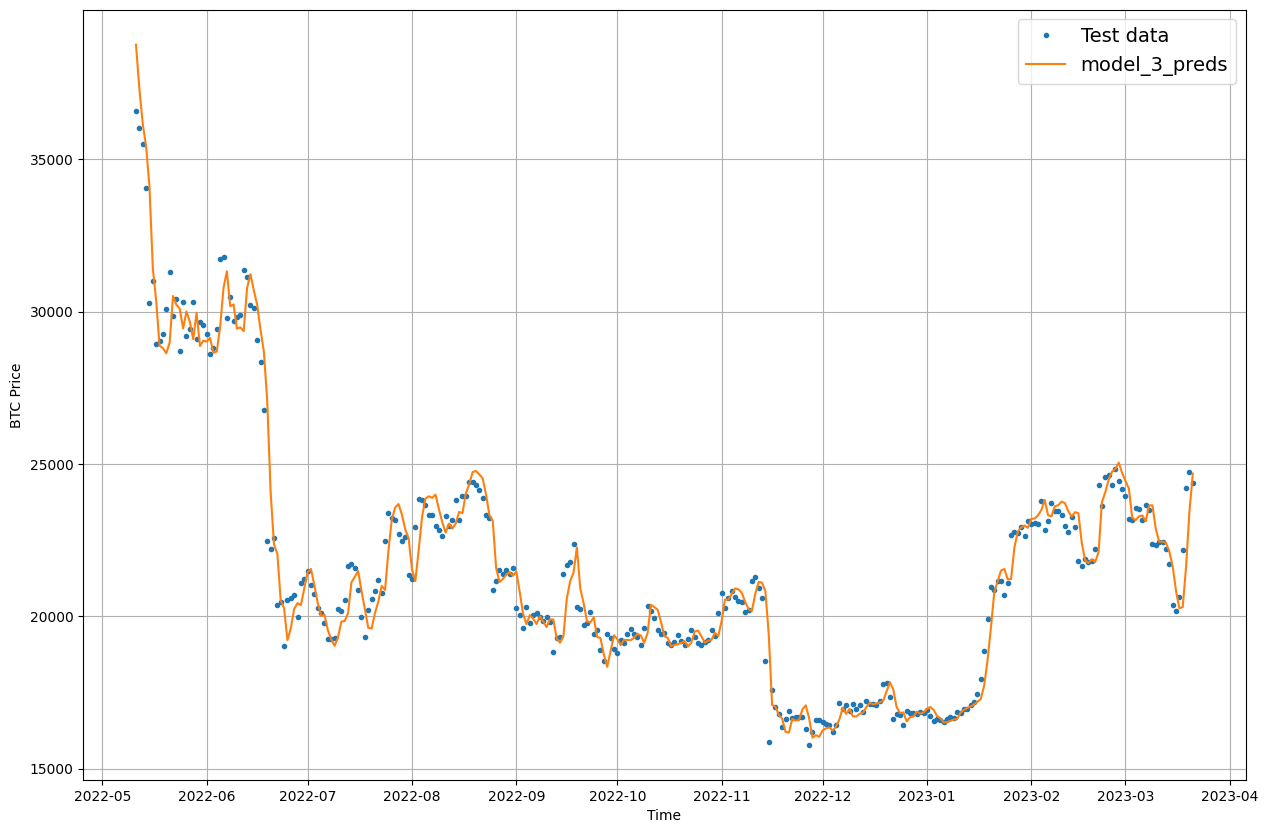

In [67]:
offset = 300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-" ,label="model_3_preds")

## Which of our model is performing best so far ?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naive model to see which model is performing the best so far.

<Axes: >

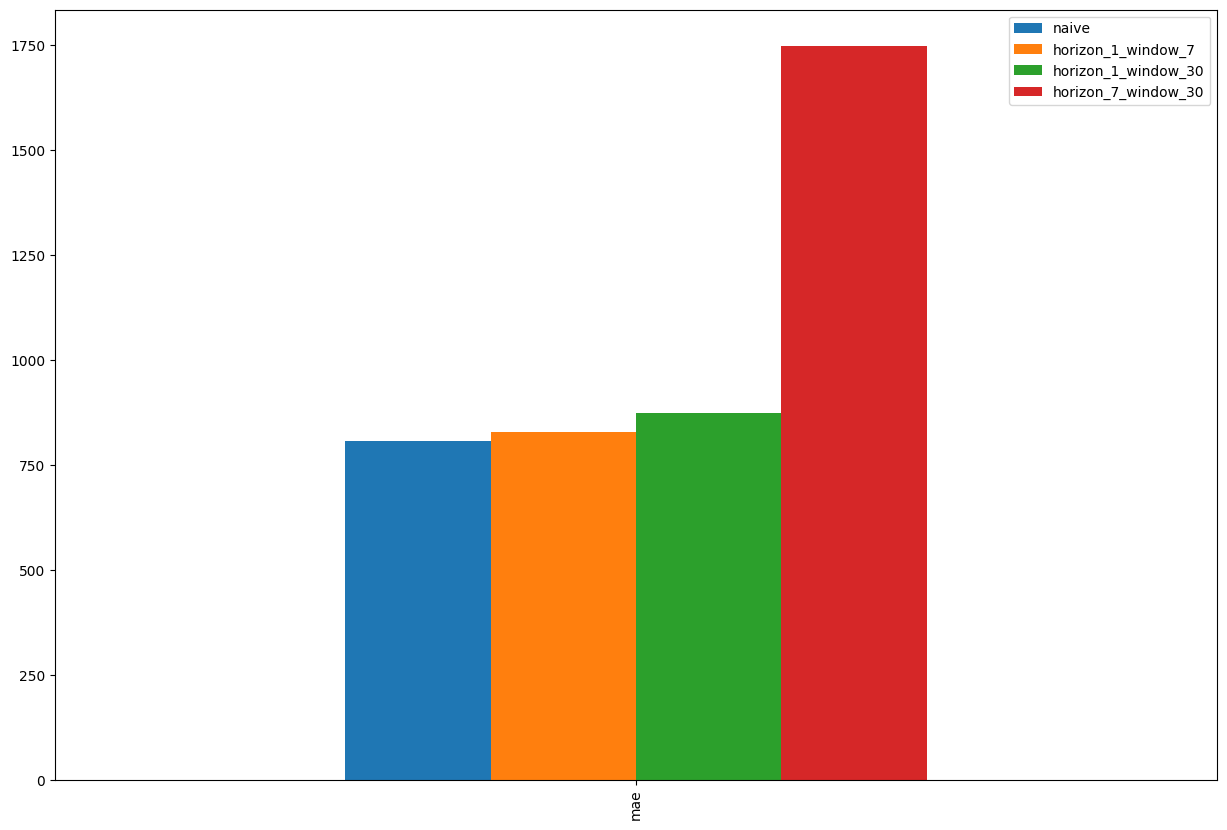

In [68]:
pd.DataFrame({"naive":naive_results['mae'],
              "horizon_1_window_7":model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']}, index=["mae"]).plot(kind='bar', figsize=(15,10))

Naive model is hard to beat in an open system, but `model_1` with HORIZON 1 and WINDOW SIZE 7 looks to be performing closest. So let's continue our experiments with only these set of horizon and window size.

💡 **Resource**: Due to autocorrelation in the time series data, naive model often performs best because the value of `t` will be closer to `t-1`. Today's value is probably pretty close to yesterday's value. This isn't always the case but when it is, a naive model will often get fairly good results.

Some more about how autocorrelation influences a model's predictions, [How (not) to use Machine learning for Time series forecasting : Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)

## Model 4 : Conv1D

We'll be using Conv1D model as it can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is many to one problem).

In [69]:
HORIZON=1
WINDOW_SIZE=7

In [70]:
# make windows for Conv1D model
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2480, 2480, 621, 621)

In [71]:
# let's see how our training data looks like
train_windows[0]

array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])

In [72]:
# convert into tensors
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

Alright, it says the shape is 7 which is the window size. But if we see the doc of [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to convert the shape of inputs into `batch size + (timesteps, input_dim)`

In [73]:
# check the shape
x.shape

TensorShape([7])

We need to convert this into (7,1). Let's create a expand dim layer to convert the inputs shape inside the layer.

In [74]:
expand_dim_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [75]:
# Test it with the x 
expand_dim_layer(x)

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[457.334],
       [424.44 ],
       [394.796],
       [408.904],
       [398.821],
       [402.152],
       [435.791]], dtype=float32)>

In [76]:
# Create the model

tf.random.set_seed(17)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='causal', activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# compile the model
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])

Epoch 1/100
15/20 [=====================>........] - ETA: 0s - loss: 6495.7710  

20/20 [==============================] - 7s 49ms/step - loss: 5668.6030 - val_loss: 6057.0796
Epoch 2/100
17/20 [========================>.....] - ETA: 0s - loss: 885.5834 

20/20 [==============================] - 1s 38ms/step - loss: 831.7378 - val_loss: 1529.1193
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 529.7664 - val_loss: 1609.6199
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 440.9981 - val_loss: 1546.4567
Epoch 5/100
17/20 [========================>.....] - ETA: 0s - loss: 439.4138

20/20 [==============================] - 1s 38ms/step - loss: 440.5061 - val_loss: 1439.4417
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 427.9238 - val_loss: 1442.1099
Epoch 7/100
16/20 [=======================>......] - ETA: 0s - loss: 428.9277

20/20 [==============================] - 1s 40ms/step - loss: 423.3100 - val_loss: 1357.4542
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 428.6798 - val_loss: 1370.4409
Epoch 9/100
17/20 [========================>.....] - ETA: 0s - loss: 403.9208

20/20 [==============================] - 1s 63ms/step - loss: 414.8029 - val_loss: 1325.8604
Epoch 10/100
20/20 [==============================] - ETA: 0s - loss: 411.7780

20/20 [==============================] - 1s 57ms/step - loss: 411.7780 - val_loss: 1319.4655
Epoch 11/100
12/20 [=================>............] - ETA: 0s - loss: 399.9521

20/20 [==============================] - 1s 51ms/step - loss: 406.0398 - val_loss: 1292.4910
Epoch 12/100
20/20 [==============================] - 0s 6ms/step - loss: 402.5692 - val_loss: 1322.4191
Epoch 13/100
16/20 [=======================>......] - ETA: 0s - loss: 417.5012

20/20 [==============================] - 1s 38ms/step - loss: 402.8450 - val_loss: 1271.4882
Epoch 14/100
20/20 [==============================] - 0s 5ms/step - loss: 386.3493 - val_loss: 1321.4384
Epoch 15/100
20/20 [==============================] - 0s 5ms/step - loss: 383.5240 - val_loss: 1380.7388
Epoch 16/100
16/20 [=======================>......] - ETA: 0s - loss: 386.2137

20/20 [==============================] - 1s 38ms/step - loss: 377.0757 - val_loss: 1204.3988
Epoch 17/100
20/20 [==============================] - 0s 6ms/step - loss: 372.1792 - val_loss: 1404.3434
Epoch 18/100
16/20 [=======================>......] - ETA: 0s - loss: 380.5892

20/20 [==============================] - 1s 39ms/step - loss: 370.3945 - val_loss: 1164.8625
Epoch 19/100
20/20 [==============================] - 0s 6ms/step - loss: 359.8706 - val_loss: 1337.8782
Epoch 20/100
16/20 [=======================>......] - ETA: 0s - loss: 378.6365

20/20 [==============================] - 1s 38ms/step - loss: 365.8183 - val_loss: 1146.0560
Epoch 21/100
16/20 [=======================>......] - ETA: 0s - loss: 346.9330

20/20 [==============================] - 1s 38ms/step - loss: 347.1188 - val_loss: 1142.0153
Epoch 22/100
20/20 [==============================] - 0s 5ms/step - loss: 340.8710 - val_loss: 1142.3754
Epoch 23/100
11/20 [===============>..............] - ETA: 0s - loss: 355.0160

20/20 [==============================] - 1s 38ms/step - loss: 341.5451 - val_loss: 1099.5564
Epoch 24/100
16/20 [=======================>......] - ETA: 0s - loss: 349.7259

20/20 [==============================] - 1s 38ms/step - loss: 342.3294 - val_loss: 1077.7598
Epoch 25/100
16/20 [=======================>......] - ETA: 0s - loss: 337.9510

20/20 [==============================] - 1s 38ms/step - loss: 329.3347 - val_loss: 1047.0264
Epoch 26/100
14/20 [====================>.........] - ETA: 0s - loss: 307.9044

20/20 [==============================] - 1s 38ms/step - loss: 322.3628 - val_loss: 1042.4430
Epoch 27/100
20/20 [==============================] - 0s 5ms/step - loss: 321.5794 - val_loss: 1096.9625
Epoch 28/100
14/20 [====================>.........] - ETA: 0s - loss: 301.6371

20/20 [==============================] - 1s 39ms/step - loss: 308.5521 - val_loss: 1014.9568
Epoch 29/100
17/20 [========================>.....] - ETA: 0s - loss: 311.0369

20/20 [==============================] - 1s 57ms/step - loss: 307.1432 - val_loss: 988.0918
Epoch 30/100
17/20 [========================>.....] - ETA: 0s - loss: 303.7631

20/20 [==============================] - 1s 44ms/step - loss: 303.9869 - val_loss: 984.0133
Epoch 31/100
20/20 [==============================] - 0s 8ms/step - loss: 295.4026 - val_loss: 996.1417
Epoch 32/100
20/20 [==============================] - 0s 8ms/step - loss: 292.3699 - val_loss: 1075.4445
Epoch 33/100
20/20 [==============================] - 0s 8ms/step - loss: 312.8364 - val_loss: 1214.8754
Epoch 34/100
12/20 [=================>............] - ETA: 0s - loss: 293.3784

20/20 [==============================] - 1s 56ms/step - loss: 290.7908 - val_loss: 934.9363
Epoch 35/100
20/20 [==============================] - ETA: 0s - loss: 281.9145

20/20 [==============================] - 1s 49ms/step - loss: 281.9145 - val_loss: 931.1049
Epoch 36/100
20/20 [==============================] - 0s 6ms/step - loss: 284.0487 - val_loss: 971.6702
Epoch 37/100
16/20 [=======================>......] - ETA: 0s - loss: 285.5395

20/20 [==============================] - 1s 39ms/step - loss: 285.3763 - val_loss: 928.4665
Epoch 38/100
20/20 [==============================] - 0s 5ms/step - loss: 282.1884 - val_loss: 945.9189
Epoch 39/100
20/20 [==============================] - 0s 6ms/step - loss: 296.2407 - val_loss: 1129.4479
Epoch 40/100
20/20 [==============================] - 0s 5ms/step - loss: 296.6958 - val_loss: 1067.3655
Epoch 41/100
20/20 [==============================] - 0s 6ms/step - loss: 311.4518 - val_loss: 1263.6129
Epoch 42/100
20/20 [==============================] - 0s 5ms/step - loss: 285.0305 - val_loss: 1050.9736
Epoch 43/100
20/20 [==============================] - 0s 6ms/step - loss: 285.4073 - val_loss: 974.9622
Epoch 44/100
20/20 [==============================] - 0s 5ms/step - loss: 292.1255 - val_loss: 1216.8245
Epoch 45/100
16/20 [=======================>......] - ETA: 0s - loss: 295.7829

20/20 [==============================] - 1s 38ms/step - loss: 284.2439 - val_loss: 899.4915
Epoch 46/100
20/20 [==============================] - 0s 6ms/step - loss: 293.9978 - val_loss: 909.1901
Epoch 47/100
20/20 [==============================] - 0s 6ms/step - loss: 272.2111 - val_loss: 901.8068
Epoch 48/100
20/20 [==============================] - 0s 6ms/step - loss: 270.2158 - val_loss: 917.8136
Epoch 49/100
17/20 [========================>.....] - ETA: 0s - loss: 263.1670

20/20 [==============================] - 1s 39ms/step - loss: 268.5240 - val_loss: 896.2780
Epoch 50/100
16/20 [=======================>......] - ETA: 0s - loss: 265.3951

20/20 [==============================] - 1s 38ms/step - loss: 266.5984 - val_loss: 890.2717
Epoch 51/100
20/20 [==============================] - 0s 6ms/step - loss: 266.7395 - val_loss: 951.6236
Epoch 52/100
20/20 [==============================] - 0s 6ms/step - loss: 272.1615 - val_loss: 901.0160
Epoch 53/100
20/20 [==============================] - 0s 5ms/step - loss: 286.7601 - val_loss: 920.7203
Epoch 54/100
20/20 [==============================] - 0s 6ms/step - loss: 272.9857 - val_loss: 904.1641
Epoch 55/100
20/20 [==============================] - 0s 5ms/step - loss: 264.6500 - val_loss: 1014.1928
Epoch 56/100
20/20 [==============================] - 0s 5ms/step - loss: 275.4005 - val_loss: 941.5611
Epoch 57/100
17/20 [========================>.....] - ETA: 0s - loss: 266.8264

20/20 [==============================] - 1s 38ms/step - loss: 264.2421 - val_loss: 878.4797
Epoch 58/100
20/20 [==============================] - 0s 5ms/step - loss: 276.4799 - val_loss: 1004.1560
Epoch 59/100
20/20 [==============================] - 0s 6ms/step - loss: 271.3943 - val_loss: 969.7418
Epoch 60/100
20/20 [==============================] - 0s 5ms/step - loss: 263.3056 - val_loss: 893.1783
Epoch 61/100
20/20 [==============================] - 0s 6ms/step - loss: 263.1742 - val_loss: 921.6242
Epoch 62/100
20/20 [==============================] - 0s 6ms/step - loss: 265.5544 - val_loss: 900.5793
Epoch 63/100
16/20 [=======================>......] - ETA: 0s - loss: 271.7305

20/20 [==============================] - 1s 37ms/step - loss: 270.8215 - val_loss: 868.1822
Epoch 64/100
20/20 [==============================] - 0s 6ms/step - loss: 278.1808 - val_loss: 904.3423
Epoch 65/100
20/20 [==============================] - 0s 6ms/step - loss: 260.5994 - val_loss: 918.6393
Epoch 66/100
20/20 [==============================] - 0s 6ms/step - loss: 291.4414 - val_loss: 1341.3282
Epoch 67/100
16/20 [=======================>......] - ETA: 0s - loss: 290.9225

20/20 [==============================] - 1s 37ms/step - loss: 283.2999 - val_loss: 864.1258
Epoch 68/100
20/20 [==============================] - 0s 6ms/step - loss: 262.8647 - val_loss: 905.0944
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 261.5302 - val_loss: 925.0318
Epoch 70/100
20/20 [==============================] - 0s 6ms/step - loss: 278.3882 - val_loss: 1009.7266
Epoch 71/100
20/20 [==============================] - 0s 5ms/step - loss: 277.6219 - val_loss: 1059.1396
Epoch 72/100
20/20 [==============================] - 0s 5ms/step - loss: 265.9844 - val_loss: 974.8560
Epoch 73/100
20/20 [==============================] - 0s 5ms/step - loss: 269.0705 - val_loss: 870.6328
Epoch 74/100
20/20 [==============================] - 0s 5ms/step - loss: 260.0290 - val_loss: 885.1569
Epoch 75/100
20/20 [==============================] - 0s 5ms/step - loss: 266.6901 - val_loss: 933.6234
Epoch 76/100
20/20 [==============================] - 0s 6ms/step - loss: 

20/20 [==============================] - 1s 68ms/step - loss: 266.2060 - val_loss: 857.1544
Epoch 78/100
11/20 [===============>..............] - ETA: 0s - loss: 260.8418

20/20 [==============================] - 1s 55ms/step - loss: 264.4280 - val_loss: 855.9888
Epoch 79/100
20/20 [==============================] - 0s 8ms/step - loss: 255.6222 - val_loss: 859.6019
Epoch 80/100
20/20 [==============================] - 0s 8ms/step - loss: 261.7879 - val_loss: 883.4365
Epoch 81/100
20/20 [==============================] - 0s 7ms/step - loss: 265.8677 - val_loss: 879.0792
Epoch 82/100
20/20 [==============================] - 0s 5ms/step - loss: 271.6554 - val_loss: 1154.7726
Epoch 83/100
20/20 [==============================] - 0s 5ms/step - loss: 273.5959 - val_loss: 964.6747
Epoch 84/100
20/20 [==============================] - 0s 6ms/step - loss: 294.7236 - val_loss: 981.3330
Epoch 85/100
17/20 [========================>.....] - ETA: 0s - loss: 278.2956

20/20 [==============================] - 1s 37ms/step - loss: 273.2699 - val_loss: 850.5192
Epoch 86/100
20/20 [==============================] - 0s 5ms/step - loss: 255.3452 - val_loss: 861.7292
Epoch 87/100
17/20 [========================>.....] - ETA: 0s - loss: 256.3028

20/20 [==============================] - 1s 38ms/step - loss: 255.8982 - val_loss: 846.2309
Epoch 88/100
20/20 [==============================] - 0s 5ms/step - loss: 253.3208 - val_loss: 891.7927
Epoch 89/100
20/20 [==============================] - 0s 5ms/step - loss: 261.3072 - val_loss: 858.6386
Epoch 90/100
20/20 [==============================] - 0s 6ms/step - loss: 260.5659 - val_loss: 1045.8680
Epoch 91/100
20/20 [==============================] - 0s 6ms/step - loss: 260.2951 - val_loss: 875.1113
Epoch 92/100
20/20 [==============================] - 0s 6ms/step - loss: 258.0895 - val_loss: 947.7938
Epoch 93/100
16/20 [=======================>......] - ETA: 0s - loss: 257.8707

20/20 [==============================] - 1s 38ms/step - loss: 258.8515 - val_loss: 846.0529
Epoch 94/100
20/20 [==============================] - 0s 6ms/step - loss: 255.7266 - val_loss: 1015.9566
Epoch 95/100
20/20 [==============================] - 0s 5ms/step - loss: 268.2279 - val_loss: 914.7274
Epoch 96/100
20/20 [==============================] - 0s 5ms/step - loss: 254.6001 - val_loss: 865.3837
Epoch 97/100
20/20 [==============================] - 0s 6ms/step - loss: 261.7953 - val_loss: 943.8905
Epoch 98/100
20/20 [==============================] - 0s 5ms/step - loss: 255.9260 - val_loss: 854.7036
Epoch 99/100
20/20 [==============================] - 0s 5ms/step - loss: 258.4107 - val_loss: 933.0079
Epoch 100/100
20/20 [==============================] - 0s 5ms/step - loss: 262.1779 - val_loss: 942.3820


In [77]:
# check the summary
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [78]:
# evaluate on the last epochs model
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 942.3821


942.3821411132812

In [79]:
# load the best model and evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 846.0529


846.0528564453125

In [80]:
# make some predictions
model_4_preds = make_predictions(model_4, test_windows)

# evaluate the results
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                   y_pred=model_4_preds)

model_4_results

20/20 [==============================] - 0s 2ms/step


{'mae': 846.05286,
 'mse': 1583025.2,
 'rmse': 1258.1833,
 'mape': 2.4453514,
 'mase': 1.0000143}

In [81]:
model_1_results

{'mae': 827.7332,
 'mse': 1553035.6,
 'rmse': 1246.2085,
 'mape': 2.3926423,
 'mase': 1.0000143}

Close enough with `model_1` but not better than it. Let's continue our experiments.

## Model 5 : RNN (LSTM)

We can also use a recurrent neural network to model our sequential time series data.

We're not going to change the data, the data will be same just the model architecture would be different.

In [82]:
tf.random.set_seed(17)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation='relu', return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, output, name="model_5_LSTM")

# compile the model
model_5.compile(loss='mae',
                optimizer='Adam')

# fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

In [83]:
# check the summary
model_5.summary()

Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            69632     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 205,377
Trainable params: 205,377
Non-tr

In [84]:
# evaluate on last epoch
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 836.5185


836.5184936523438

In [85]:
# load the best model and evaluate
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 836.5185


836.5184936523438

In [86]:
# make predictions and check pred results
model_5_preds = make_predictions(model_5, test_windows)

model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)

model_5_results

20/20 [==============================] - 0s 2ms/step


{'mae': 836.5185,
 'mse': 1565531.1,
 'rmse': 1251.2118,
 'mape': 2.4167602,
 'mase': 1.0000143}

## Make a Multivariate time series

So far all our models predicted on univariate time series data which is only Bitcoin prices, but what are other features that may impact the price of bitcoin, that's the thing to explore.


What about the Volume ? Or Block Reward ? Could be a tweet from a famous personality like Elon Musk can fluctuate the prices. 

According to the data we have, we can use Volume and Block Reward. Then let's add these two features into our time series dataset.

In [87]:
# view the dataset
bitcoin_prices.tail()

,Price
Date,
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781
2023-03-20,27767.236328
2023-03-21,27964.888672


According to the [CMC Markets](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving) block reward events, we can assign the block reward to specific date range in our dataset.

| Block Reward	| Start Date |
| --- | --- |
| 50	| 3 January 2009 (2009-01-03) |
| 25	| 28 November 2012 |
| 12.5 |	9 July 2016 |
| 6.25 |	11 May 2020 |
| 3.125	|TBA (expected 2024) |
| 1.5625 |	TBA (expected 2028) |


And we have a data between **`2014 Sept 17th`** - **`2023 March 17th`**. Great.


In [88]:
# Block reward values
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25
block_reward_5 = 3.125 # not required for our dataset

# Block reward dates
block_reward_1_date = np.datetime64("2009-01-03")
block_reward_2_date = np.datetime64("2012-11-28")
block_reward_3_date = np.datetime64("2016-07-09")
block_reward_4_date = np.datetime64("2020-05-11")
block_reward_5_date = np.datetime64("2024-04-01") # expected to be april

Let's get the number of days fall between the block reward dates in our time series dataset.

In [89]:
block_reward_2_days = (block_reward_3_date - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_date - bitcoin_prices.index[0]).days
block_reward_4_days = (block_reward_5_date - bitcoin_prices.index[0]).days

block_reward_2_days, block_reward_3_days, block_reward_4_days

(661, 2063, 3484)

Now add the new feature `block_reward` in our dataset.

In [90]:
# Add block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column
                          # row, column
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:block_reward_4_days, -1] = block_reward_4
bitcoin_prices_block.iloc[block_reward_4_days:, -1] = block_reward_5

Let's view head and tail of data.

In [91]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25


In [92]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2023-03-17,27423.929688,6.25
2023-03-18,26965.878906,6.25
2023-03-19,28038.675781,6.25
2023-03-20,27767.236328,6.25
2023-03-21,27964.888672,6.25


Let's plot it to see how it looks like together.

<Axes: xlabel='Date'>

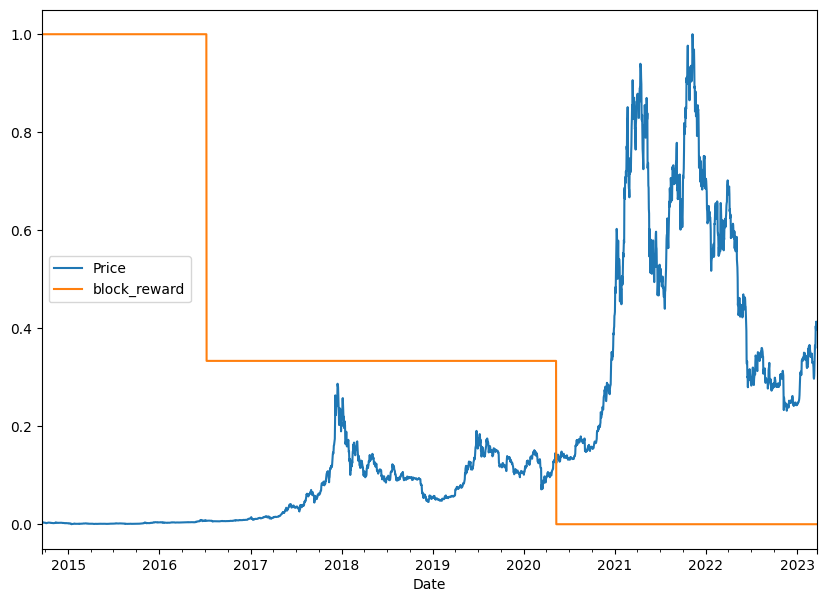

In [93]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7))

In the above plot when we set the same scale for prices and block reward, we can see the Prices go up when block reward get reduced.

## Making a windowed dataset with pandas

Previously we created some custom function to window our univariate time series.

Since we have added one more variable to our dataset, these functions won't work.

In pandas, there is a function called [`.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html), which can be used to create windows on multivariate time series dataset.


In [94]:
# Setup dataset hyperparameters
HORIZON=1
WINDOW_SIZE=7

In [95]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)               

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


Alright, we need to drop NaNs and make feature set and label set.

In [96]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

# Make train test split
split_size = int(len(X) * 0.8) # 80%
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

X_train.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [97]:
X_train.shape, X_test.shape

((2480, 8), (621, 8))

## Model 6 : Multivariate Time Series (Dense model)

We're going to build the same model like `model_1` architecture and use it to train and make predictions on our multivariate time series data.

In [98]:
tf.random.set_seed(17)

# Create the model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], "model_6_multivariate_dense")

# Compile the model
model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name="model_6_multivariate_dense")])

Epoch 1/100
19/20 [===========================>..] - ETA: 0s - loss: 3860.1543 

20/20 [==============================] - 2s 35ms/step - loss: 3803.9270 - val_loss: 4782.3599
Epoch 2/100
18/20 [==========================>...] - ETA: 0s - loss: 881.0177 

20/20 [==============================] - 1s 42ms/step - loss: 863.7647 - val_loss: 1967.3468
Epoch 3/100
14/20 [====================>.........] - ETA: 0s - loss: 545.8574

20/20 [==============================] - 1s 39ms/step - loss: 533.2169 - val_loss: 1528.9683
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 441.7466 - val_loss: 1592.4607
Epoch 5/100
15/20 [=====================>........] - ETA: 0s - loss: 435.6725

20/20 [==============================] - 1s 41ms/step - loss: 433.2325 - val_loss: 1392.0682
Epoch 6/100
19/20 [===========================>..] - ETA: 0s - loss: 415.6494

20/20 [==============================] - 1s 27ms/step - loss: 415.4167 - val_loss: 1390.6831
Epoch 7/100
18/20 [==========================>...] - ETA: 0s - loss: 402.8481

20/20 [==============================] - 1s 28ms/step - loss: 402.9633 - val_loss: 1262.7400
Epoch 8/100
18/20 [==========================>...] - ETA: 0s - loss: 411.9597

20/20 [==============================] - 1s 28ms/step - loss: 419.3588 - val_loss: 1249.1250
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 392.7963 - val_loss: 1377.7058
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 374.2380 - val_loss: 1269.1952
Epoch 11/100
20/20 [==============================] - ETA: 0s - loss: 362.0950

20/20 [==============================] - 1s 27ms/step - loss: 362.0950 - val_loss: 1174.9796
Epoch 12/100
15/20 [=====================>........] - ETA: 0s - loss: 362.7480

20/20 [==============================] - 1s 28ms/step - loss: 357.6346 - val_loss: 1136.3292
Epoch 13/100
20/20 [==============================] - 0s 5ms/step - loss: 347.1987 - val_loss: 1161.0863
Epoch 14/100
20/20 [==============================] - 0s 5ms/step - loss: 341.5927 - val_loss: 1276.0554
Epoch 15/100
20/20 [==============================] - 0s 5ms/step - loss: 337.7495 - val_loss: 1211.8777
Epoch 16/100
19/20 [===========================>..] - ETA: 0s - loss: 333.6856

20/20 [==============================] - 1s 28ms/step - loss: 334.7812 - val_loss: 1121.5544
Epoch 17/100
18/20 [==========================>...] - ETA: 0s - loss: 321.9645

20/20 [==============================] - 1s 28ms/step - loss: 327.2939 - val_loss: 1063.8025
Epoch 18/100
19/20 [===========================>..] - ETA: 0s - loss: 325.7228

20/20 [==============================] - 1s 28ms/step - loss: 331.1487 - val_loss: 1053.7808
Epoch 19/100
20/20 [==============================] - 0s 5ms/step - loss: 323.2741 - val_loss: 1164.9404
Epoch 20/100
20/20 [==============================] - 0s 5ms/step - loss: 332.4406 - val_loss: 1054.8970
Epoch 21/100
20/20 [==============================] - ETA: 0s - loss: 326.0640

20/20 [==============================] - 1s 45ms/step - loss: 326.0640 - val_loss: 1028.1565
Epoch 22/100
20/20 [==============================] - 0s 5ms/step - loss: 319.0204 - val_loss: 1030.5229
Epoch 23/100
20/20 [==============================] - 0s 5ms/step - loss: 315.4752 - val_loss: 1477.8513
Epoch 24/100
20/20 [==============================] - 0s 6ms/step - loss: 362.7741 - val_loss: 1245.1591
Epoch 25/100
20/20 [==============================] - 0s 5ms/step - loss: 314.8560 - val_loss: 1057.4993
Epoch 26/100
20/20 [==============================] - 0s 5ms/step - loss: 302.8623 - val_loss: 1036.6135
Epoch 27/100
20/20 [==============================] - 0s 6ms/step - loss: 307.1819 - val_loss: 1064.4933
Epoch 28/100
20/20 [==============================] - ETA: 0s - loss: 294.3141

20/20 [==============================] - 1s 28ms/step - loss: 294.3141 - val_loss: 1024.8964
Epoch 29/100
20/20 [==============================] - 0s 6ms/step - loss: 295.8512 - val_loss: 1025.4062
Epoch 30/100
19/20 [===========================>..] - ETA: 0s - loss: 295.4493

20/20 [==============================] - 1s 27ms/step - loss: 295.8915 - val_loss: 1000.4156
Epoch 31/100
20/20 [==============================] - ETA: 0s - loss: 289.7573

20/20 [==============================] - 1s 27ms/step - loss: 289.7573 - val_loss: 974.7384
Epoch 32/100
20/20 [==============================] - 0s 5ms/step - loss: 287.0219 - val_loss: 1005.7043
Epoch 33/100
19/20 [===========================>..] - ETA: 0s - loss: 285.2869

20/20 [==============================] - 1s 28ms/step - loss: 289.3393 - val_loss: 966.0791
Epoch 34/100
20/20 [==============================] - 0s 5ms/step - loss: 290.5252 - val_loss: 967.6323
Epoch 35/100
20/20 [==============================] - ETA: 0s - loss: 296.0565

20/20 [==============================] - 1s 28ms/step - loss: 296.0565 - val_loss: 962.2923
Epoch 36/100
20/20 [==============================] - 0s 5ms/step - loss: 290.0201 - val_loss: 1145.1818
Epoch 37/100
19/20 [===========================>..] - ETA: 0s - loss: 299.1931

20/20 [==============================] - 1s 37ms/step - loss: 296.8605 - val_loss: 958.6517
Epoch 38/100
20/20 [==============================] - 0s 8ms/step - loss: 279.4480 - val_loss: 1048.5891
Epoch 39/100
20/20 [==============================] - 0s 7ms/step - loss: 305.6126 - val_loss: 1128.5077
Epoch 40/100
20/20 [==============================] - 0s 7ms/step - loss: 316.3539 - val_loss: 1377.5049
Epoch 41/100
20/20 [==============================] - 0s 7ms/step - loss: 342.8083 - val_loss: 1524.3857
Epoch 42/100
20/20 [==============================] - 0s 7ms/step - loss: 298.8439 - val_loss: 1030.4071
Epoch 43/100
14/20 [====================>.........] - ETA: 0s - loss: 270.3322

20/20 [==============================] - 1s 42ms/step - loss: 279.6192 - val_loss: 931.0275
Epoch 44/100
20/20 [==============================] - 0s 8ms/step - loss: 275.3428 - val_loss: 1004.6567
Epoch 45/100
14/20 [====================>.........] - ETA: 0s - loss: 297.4864

20/20 [==============================] - 1s 31ms/step - loss: 282.5902 - val_loss: 925.3560
Epoch 46/100
20/20 [==============================] - ETA: 0s - loss: 280.0056

20/20 [==============================] - 1s 27ms/step - loss: 280.0056 - val_loss: 922.3829
Epoch 47/100
20/20 [==============================] - 0s 6ms/step - loss: 273.6639 - val_loss: 961.4775
Epoch 48/100
20/20 [==============================] - 0s 5ms/step - loss: 285.0430 - val_loss: 950.0988
Epoch 49/100
19/20 [===========================>..] - ETA: 0s - loss: 273.0728

20/20 [==============================] - 1s 27ms/step - loss: 275.3527 - val_loss: 915.7219
Epoch 50/100
20/20 [==============================] - 0s 5ms/step - loss: 270.8924 - val_loss: 925.4987
Epoch 51/100
20/20 [==============================] - 0s 5ms/step - loss: 271.5041 - val_loss: 941.4844
Epoch 52/100
20/20 [==============================] - ETA: 0s - loss: 270.5135

20/20 [==============================] - 1s 28ms/step - loss: 270.5135 - val_loss: 913.9149
Epoch 53/100
20/20 [==============================] - 0s 5ms/step - loss: 286.1661 - val_loss: 1028.5952
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 279.6463 - val_loss: 958.0869
Epoch 55/100
20/20 [==============================] - 0s 5ms/step - loss: 280.2989 - val_loss: 1045.6140
Epoch 56/100
20/20 [==============================] - ETA: 0s - loss: 277.5303

20/20 [==============================] - 1s 27ms/step - loss: 277.5303 - val_loss: 901.3763
Epoch 57/100
17/20 [========================>.....] - ETA: 0s - loss: 274.1885

20/20 [==============================] - 1s 27ms/step - loss: 270.6903 - val_loss: 898.2548
Epoch 58/100
20/20 [==============================] - 0s 5ms/step - loss: 278.5148 - val_loss: 1029.0018
Epoch 59/100
20/20 [==============================] - ETA: 0s - loss: 271.2979

20/20 [==============================] - 1s 27ms/step - loss: 271.2979 - val_loss: 895.4879
Epoch 60/100
20/20 [==============================] - 0s 6ms/step - loss: 263.3563 - val_loss: 898.9981
Epoch 61/100
20/20 [==============================] - 0s 5ms/step - loss: 286.0202 - val_loss: 955.2415
Epoch 62/100
20/20 [==============================] - 0s 5ms/step - loss: 282.5708 - val_loss: 901.0071
Epoch 63/100
20/20 [==============================] - 0s 5ms/step - loss: 271.2027 - val_loss: 984.7249
Epoch 64/100
20/20 [==============================] - 0s 5ms/step - loss: 283.5951 - val_loss: 941.4545
Epoch 65/100
20/20 [==============================] - ETA: 0s - loss: 271.8111

20/20 [==============================] - 1s 28ms/step - loss: 271.8111 - val_loss: 887.9998
Epoch 66/100
20/20 [==============================] - 0s 5ms/step - loss: 278.5565 - val_loss: 898.4438
Epoch 67/100
20/20 [==============================] - 0s 5ms/step - loss: 297.3505 - val_loss: 1061.0321
Epoch 68/100
20/20 [==============================] - 0s 5ms/step - loss: 272.5631 - val_loss: 891.7631
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 265.3275 - val_loss: 914.8124
Epoch 70/100
20/20 [==============================] - 0s 5ms/step - loss: 270.3124 - val_loss: 1095.2834
Epoch 71/100
20/20 [==============================] - 0s 5ms/step - loss: 274.3466 - val_loss: 900.4958
Epoch 72/100
20/20 [==============================] - 0s 5ms/step - loss: 261.8965 - val_loss: 1084.5460
Epoch 73/100
20/20 [==============================] - 0s 5ms/step - loss: 283.1438 - val_loss: 986.1489
Epoch 74/100
20/20 [==============================] - ETA: 0s - loss: 261

20/20 [==============================] - 1s 26ms/step - loss: 261.9381 - val_loss: 887.6205
Epoch 75/100
19/20 [===========================>..] - ETA: 0s - loss: 258.2196

20/20 [==============================] - 1s 27ms/step - loss: 259.4389 - val_loss: 872.7518
Epoch 76/100
19/20 [===========================>..] - ETA: 0s - loss: 257.5930

20/20 [==============================] - 1s 27ms/step - loss: 257.9678 - val_loss: 871.4634
Epoch 77/100
20/20 [==============================] - 0s 5ms/step - loss: 259.5215 - val_loss: 930.9238
Epoch 78/100
20/20 [==============================] - 0s 5ms/step - loss: 270.2192 - val_loss: 902.5050
Epoch 79/100
 1/20 [>.............................] - ETA: 0s - loss: 261.9442

20/20 [==============================] - 1s 26ms/step - loss: 261.6718 - val_loss: 867.7949
Epoch 80/100
20/20 [==============================] - 0s 5ms/step - loss: 269.5953 - val_loss: 945.8272
Epoch 81/100
20/20 [==============================] - 0s 5ms/step - loss: 270.3771 - val_loss: 903.0731
Epoch 82/100
20/20 [==============================] - 0s 5ms/step - loss: 274.1592 - val_loss: 1091.8484
Epoch 83/100
20/20 [==============================] - 0s 5ms/step - loss: 291.5634 - val_loss: 1145.4526
Epoch 84/100
20/20 [==============================] - 0s 5ms/step - loss: 337.4554 - val_loss: 1184.2194
Epoch 85/100
20/20 [==============================] - 0s 5ms/step - loss: 286.2445 - val_loss: 923.2027
Epoch 86/100
19/20 [===========================>..] - ETA: 0s - loss: 259.3713

20/20 [==============================] - 1s 27ms/step - loss: 262.0351 - val_loss: 861.9372
Epoch 87/100
18/20 [==========================>...] - ETA: 0s - loss: 257.9856

20/20 [==============================] - 1s 62ms/step - loss: 256.8772 - val_loss: 861.1888
Epoch 88/100
20/20 [==============================] - 0s 7ms/step - loss: 260.1928 - val_loss: 875.3770
Epoch 89/100
20/20 [==============================] - 0s 7ms/step - loss: 260.8798 - val_loss: 869.6730
Epoch 90/100
20/20 [==============================] - 0s 7ms/step - loss: 258.8939 - val_loss: 953.0939
Epoch 91/100
20/20 [==============================] - 0s 7ms/step - loss: 257.0150 - val_loss: 875.9082
Epoch 92/100
15/20 [=====================>........] - ETA: 0s - loss: 261.6142

20/20 [==============================] - 1s 43ms/step - loss: 257.7583 - val_loss: 857.4540
Epoch 93/100
20/20 [==============================] - 0s 5ms/step - loss: 270.2361 - val_loss: 859.9239
Epoch 94/100
20/20 [==============================] - 0s 6ms/step - loss: 264.5059 - val_loss: 1181.6086
Epoch 95/100
20/20 [==============================] - 0s 5ms/step - loss: 286.0541 - val_loss: 934.7776
Epoch 96/100
20/20 [==============================] - 0s 5ms/step - loss: 262.3818 - val_loss: 927.6276
Epoch 97/100
20/20 [==============================] - 0s 4ms/step - loss: 278.6258 - val_loss: 958.5489
Epoch 98/100
19/20 [===========================>..] - ETA: 0s - loss: 258.6259

20/20 [==============================] - 1s 28ms/step - loss: 258.0765 - val_loss: 854.2983
Epoch 99/100
20/20 [==============================] - 0s 5ms/step - loss: 258.0798 - val_loss: 977.7964
Epoch 100/100
20/20 [==============================] - 0s 5ms/step - loss: 262.2663 - val_loss: 875.6324


In [99]:
# evaluate on last epoch
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 875.6324


875.6324462890625

In [100]:
# load the best model and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_multivariate_dense/")
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 854.2985


854.2985229492188

In [101]:
# Make prediction
model_6_preds = make_predictions(model_6, X_test)

model_6_preds[:2]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([32956.266, 33543.44 ], dtype=float32)>

In [102]:
# evaluate preds
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

{'mae': 854.2985,
 'mse': 1610958.5,
 'rmse': 1269.2354,
 'mape': 2.4721117,
 'mase': 1.0000143}

In [103]:
model_1_results

{'mae': 827.7332,
 'mse': 1553035.6,
 'rmse': 1246.2085,
 'mape': 2.3926423,
 'mase': 1.0000143}

Oh great, we got the almost the same results as `model_1` but still `naive forecast` is the best so far.

In [104]:
naive_results

{'mae': 807.2706,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000143}

## Model 7 : N-BEATS Algorithm

So far we've tried on smaller models, models with only a couple of layers.

But one of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Bases Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state of the art performance in the winner of the M4 competition (a forecasting competition).

For our next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm ([section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))



### Building and Testing an N-BEATS block layer

Let's start by building an N-BEATS block layer, we'll write the code first and then discuss what's going on.

In [105]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size:int,
               theta_size:int,
               horizon:int,
               n_neurons:int,
               n_layers:int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each ReLu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [106]:
# set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [107]:
# create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [108]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.06313059 -0.25084788  0.24330154  0.34729645 -0.39602908  0.20929658
 -0.817763  ]
Forecast: -0.34858906269073486


### Preparing data for the N-BEATS algorithm using `tf.data`

This time, we're going to be using a larger model architecture, to ensure our model training runs as fast as possible, we'll setup our datasets using the `tf.data` API.

In [109]:
HORIZON=1
WINDOW_SIZE=7

In [110]:
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [111]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN


In [112]:
# Drop NaN & create feature and label dataset
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test split
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test)

(2480, 621)

In [113]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine the labels and features using .zip()
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Create the Batch and Prefetch the Datasets using batch() and prefetch()
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting Up Hyperparameters for N-BEATS algorithm

Setting up the hyperparameters for the N-BEATS architecture as mentioned in Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)


In [114]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before jump into creating N-BEATS model, there are two layers to go through which play a large role in the architecture.

They're what make N-BEATS double residual stacking (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:

- `tf.keras.layers.subtract(inputs)`
- `tf.keras.layers.add(inputs)`

In [115]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract 
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

tensor_1, tensor_2, subtracted, added

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32)>)

### Building, compiling and fitting the N-BEATS algorithm

Okay, we've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using NBeatsBlock (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the `Keras Functional API` for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper)
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  - `tf.keras.callbacks.EarlyStopping()` - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True (this'll prevent the model from training for loooongggggg period of time without improvement)
  - `tf.keras.callbacks.ReduceLROnPlateau()` - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)


In [116]:
%%time

tf.random.set_seed(17)

# 1. Setup an instance of N-BEATS block layer using NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock')

# 2. Create an input layer for the N-BEATS stack
stack_input = layers.Input(shape=(INPUT_SIZE), name='stack_input')

# 3. Make the initial backcast and forecast
backcast, forecast = nbeats_block_layer(stack_input)
# Add in substraction residual link
residuals = layers.subtract([stack_input, backcast], name='subtract_00')

# 4. Use a for loop to create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)):
  # 5. Use the NBeatsBlock class within the for loop
  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                         theta_size=THETA_SIZE,
                                         horizon=HORIZON,
                                         n_neurons=N_NEURONS,
                                         n_layers=N_LAYERS,
                                         name=f'NBeatsBlock_{i}')(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f'subtract_{i}')
  forecast = layers.add([forecast, block_forecast], name=f'add_{i}')

# 7. Put the model inputs and outputs together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name='model_7_NBeats')

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mae', 'mse'])

# 9. Fit the model with EarlyStoppping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,            
            epochs=N_EPOCHS,
            verbose=0,
            validation_data=test_dataset,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            patience=100,
                                                            verbose=1)])


Epoch 393: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 493: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 2min 27s, sys: 3.39 s, total: 2min 30s
Wall time: 2min 43s


In [117]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 24ms/step - loss: 834.6839 - mae: 834.6839 - mse: 1574970.6250


[834.6838989257812, 834.6838989257812, 1574970.625]

In [118]:
# make predictions
model_7_preds = make_predictions(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33151.613, 33739.734, 33622.53 , 34098.645, 33318.97 , 32660.111,
       32798.297, 32018.033, 31928.273, 31572.225], dtype=float32)>

In [119]:
# evaluate results
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 834.6839,
 'mse': 1574970.6,
 'rmse': 1254.9783,
 'mape': 2.413484,
 'mase': 1.0000143}

In [120]:
naive_results

{'mae': 807.2706,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000143}

Even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fast not all the larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created



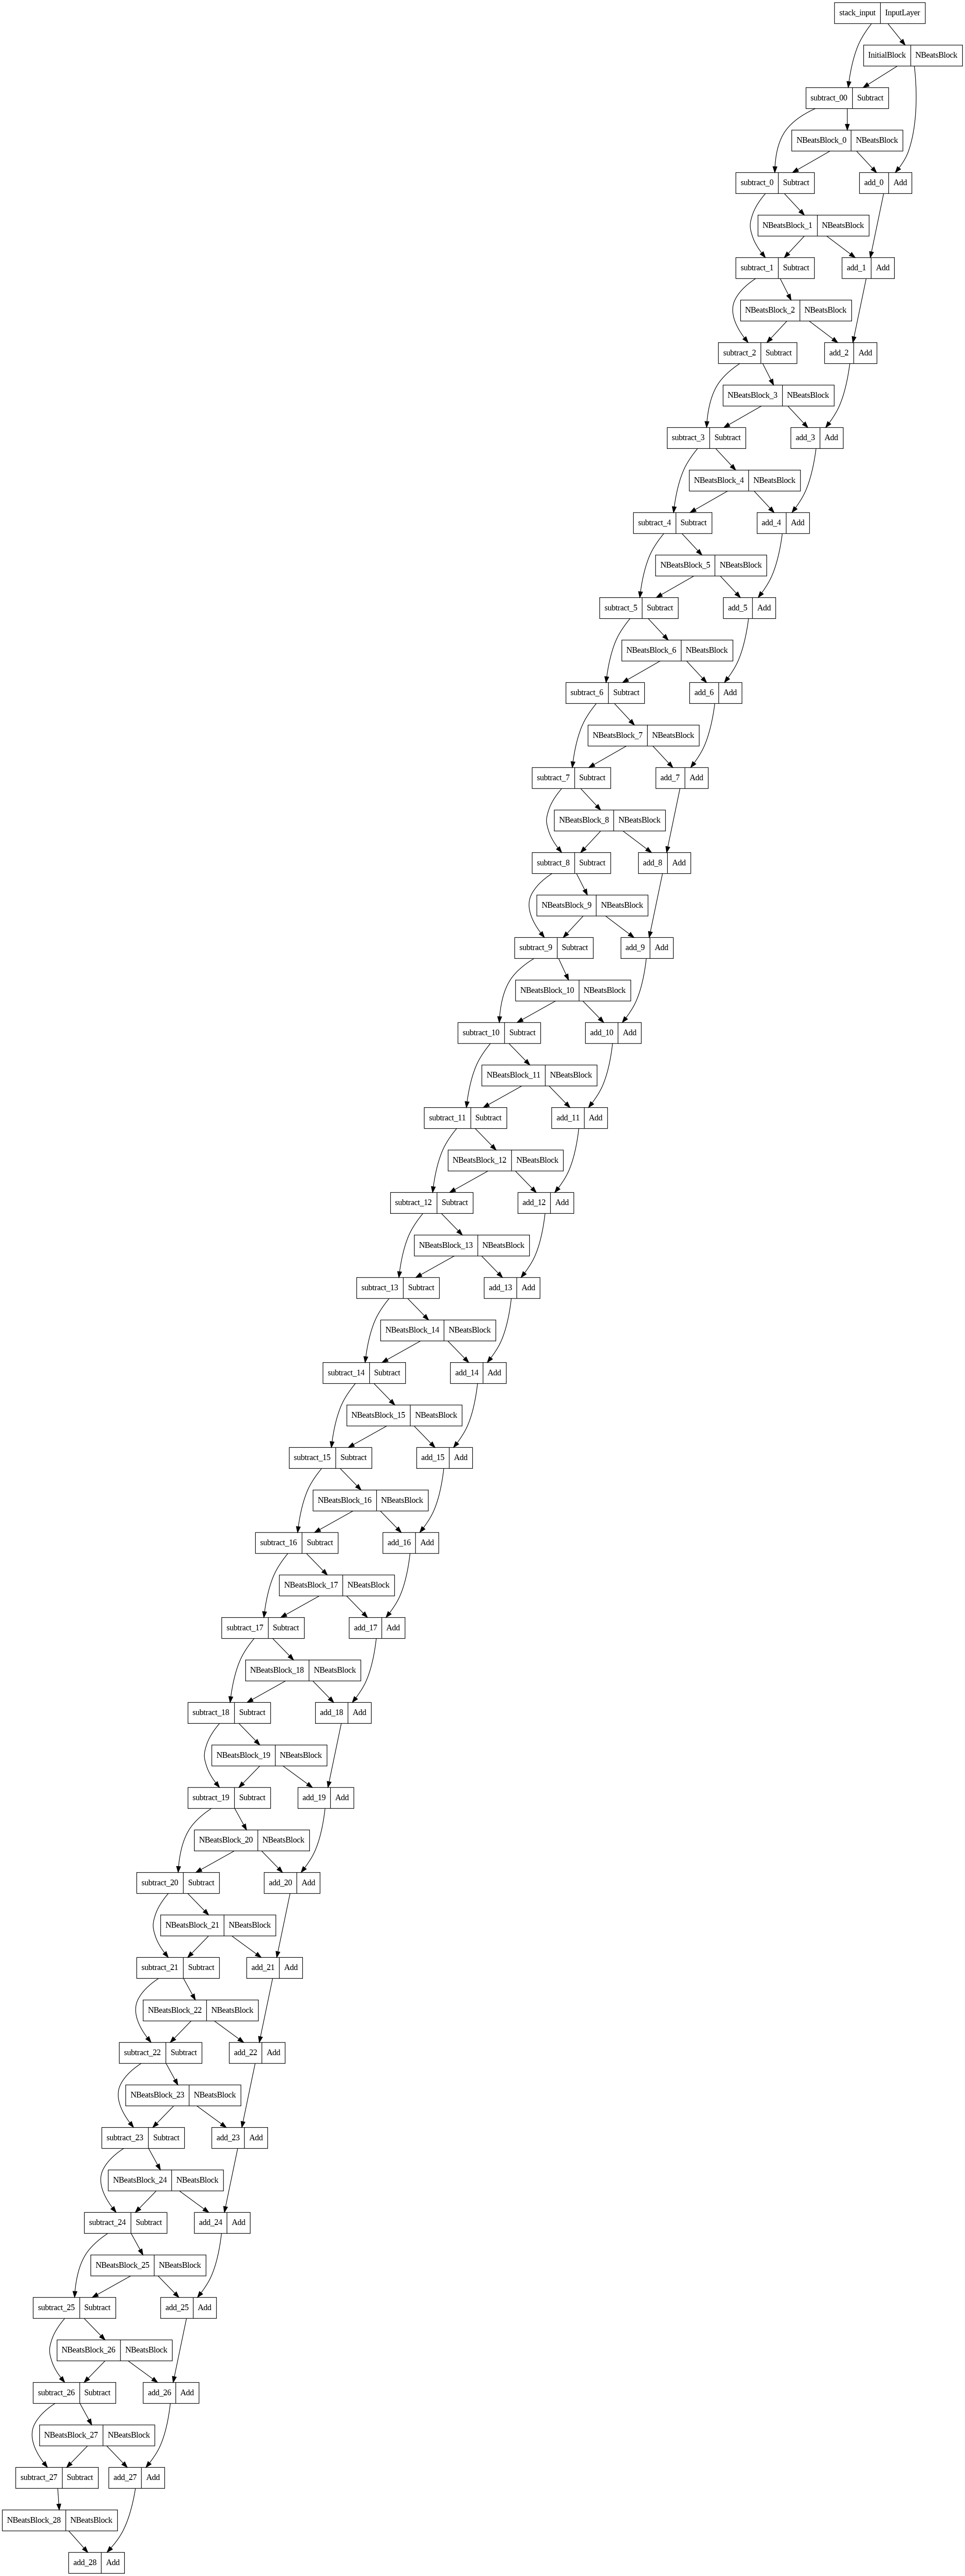

In [121]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8 : Creating an ensemble (stacking different models together)

Our next experiment is creating an [ensemble of models](https://en.wikipedia.org/wiki/Ensemble_learning).

An ensemble involves training and combining multiple different models on the same problem. Ensemble models are often the types of models you'll see winning data science competitions on websites like kaggle.

### Construction and fitting an ensemble of models (using different loss functions)

In [122]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae","mse","mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned.
  10 * ["mae", "mse", "mape"]
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple dense model
      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
          layers.Dense(HORIZON)
      ])

      # compile a model
      model.compile(loss=f"{loss_function}",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae","mse"])
      
      # fit the model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                patience=100,
                                                                verbose=1)])
      
      # append the fitted model
      ensemble_models.append(model)
  return ensemble_models

In [123]:
%%time
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 476: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 576: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 438: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 550: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 650: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 562: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 675: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 775: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 455: ReduceLROnPl

In [124]:
# list out the ensemble models
ensemble_models

### Make predictions with ensemble models

In [125]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [126]:
# create the list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 43ms/step


<tf.Tensor: shape=(15, 621), dtype=float32, numpy=
array([[33266.734, 34206.938, 34079.54 , ..., 27219.998, 28330.506,
        27864.012],
       [33017.74 , 33909.246, 33354.906, ..., 27292.016, 28239.844,
        27736.596],
       [32865.1  , 33747.18 , 33398.266, ..., 27185.068, 28058.17 ,
        27942.213],
       ...,
       [32966.066, 33408.668, 33758.48 , ..., 26704.785, 27807.502,
        27690.791],
       [32993.395, 33550.734, 33269.26 , ..., 27103.896, 28161.498,
        27647.025],
       [32854.836, 33711.293, 33426.117, ..., 27209.162, 28165.824,
        27934.215]], dtype=float32)>

Now we have got a set of ensemble predictions, we can evaluate them against the ground truth values.

However, since we've trained 15 models, there's going to be 15 sets of predictions. Rather than comparing every set of predictions to the ground truth, let's take the median or mean (but [median is usually more robust than mean](https://www.johndcook.com/blog/2009/03/06/student-t-distribution-mean-median/))



In [127]:
# evaluate ensemble predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))

ensemble_results

{'mae': 815.82544,
 'mse': 1507559.0,
 'rmse': 1227.8269,
 'mape': 2.3564527,
 'mase': 1.0000143}

In [128]:
model_1_results

{'mae': 827.7332,
 'mse': 1553035.6,
 'rmse': 1246.2085,
 'mape': 2.3926423,
 'mase': 1.0000143}

In [129]:
naive_results

{'mae': 807.2706,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000143}

Looks like now we have a change in 2nd spot of best performing models, `ensemble models` performed better than `model_1` which was earlier in the 2nd spot.